# Fusion Simulator Code 
Author: Zara Zenia Ercan

Fusion simulator code adapted from Frank Schoofs and Tom N. Todd https://figshare.com/articles/software/Fusion_reactor_calculator/16850191?file=31153591

In [51]:
# All necessary packages
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from itertools import product
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve
import shap
import math
import warnings
warnings.filterwarnings("ignore")

In [52]:
"""
Reactor calculator

Calculate fusion reactor parameters based on a set of plasma physics and engineering inputs.

Contains functions: sigmav_DT, _f_sv and calculate_reactor_parameters.

Copyright © 2021 Frank Schoofs, Tom N. Todd
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

"""

qe = 1.6021773e-19 # C
mu0 = 1.25663706212e-6 # H/m

def sigmav_DT(Ti0,model):
    '''
    Calculate the <sigma v> for D-T reaction based on the formula from DOI:10.1016/j.fusengdes.2012.02.025

    Parameters
    ----------
    Ti0 : float
        Ion temperature in keV (0<Ti<=100).

    Returns
    -------
    Maxwellian reactivitiy for D-T reaction

    '''
    c1 = 2.5663271e-18
    c2 = 19.983026
    c3 = 2.5077133e-2
    c4 = 2.5773408e-3
    c5 = 6.1880463e-5
    c6 = 6.6024089e-2
    c7 = 8.1215505e-3
    U = 1-Ti0*(c3+Ti0*(c4-c5*Ti0))/(1+Ti0*(c6+c7*Ti0))
    val = c1/(np.power(U,5/6)*np.power(Ti0,2/3))*np.exp(-c2*np.power(U/Ti0,1/3))
    return val

def _f_sv(Ti0):
    '''
    Parameters
    ----------
    Ti : float
        Temperature in keV

    Returns
    -------
    f_alpha_sigma-v: float
        Ratio of profile peaking factor alpha_sigma-v to alpha_T

    '''
    return 1.26*np.log(100/Ti0)


def calculate_reactor_parameters(R_cc,B_max,Q,reactor_param):
    '''
    Parameters
    ----------
    R_cc : float
        Radius of leg of inboard TF coil vault (R_TF,in)
    B_max : float
        Maximum magnetic field on inboard TF coil (B_TF,max)
    Q : float
        Q value for the reactor
    reactor_param : dict
        Dictionary containing reactor parameters

    Returns
    -------
    reactor_data_dict : dict
        Dictionairy containing the major calculated reactor parameters as well as plasma physics check flags



    Example use:
        > stfpp_param = {'q95':8,'delta':5,'l_i':0.5,'alpha_n':0.2,'alpha_T':1.7,\
               'f_Greenwald':0.9,'f_core_rad':0.4,'Z_i':12,'Z_eff':1.6,\
               'EMF':1.2,'gamma_CD':0.36,'eta_gen':0.375,'eta_CD':0.4,\
                   'f_BOP':0.35,'H':1.2,'A':1.8,'kappa_nat_multip':1.8,'t_shield':0.85}
        > df = calculate_reactor_parameters(0.9,20.,20.,stfpp_param)

    '''
    # Major radius
    R_0 = (R_cc+reactor_param['t_shield'])/(1-1/reactor_param['A']) # m

    # Minor radius
    a = R_0/reactor_param['A'] # m

    # Toroidal magnetic field on plasma
    B_0 = B_max*R_cc/R_0 # T

    # Elongation
    kappa = reactor_param['kappa_nat_multip']*(1+(0.6306/reactor_param['l_i'] + 0.1064/np.power(reactor_param['l_i'],2))/np.power(reactor_param['A'],2) + (0.1952/reactor_param['l_i'] - 0.2439/np.power(reactor_param['l_i'],2))/np.power(reactor_param['A'],4))
    
    # Plasma current
    I_p = 5/reactor_param['q95']*a*B_0/reactor_param['A']*(1+np.power(kappa,2)*(1+2*reactor_param['delta']**2-1.2*reactor_param['delta']**3))/2*(1.17-0.65/reactor_param['A'])/(np.power(1-np.power(reactor_param['A'],-2),2)) # MA
    qstar = 2.5*a*B_0*(1+np.power(kappa,2))/(reactor_param['A']*I_p)
    C_BS = 0.234*np.power(1+reactor_param['alpha_n']+reactor_param['alpha_T'],0.8) # calculated from Andrade & Ludwig fit
    
    # Greenwald density
    nG = 1*I_p/(np.pi*np.power(a,2)) # 1e20/m3

    # Electron density
    ne20 = reactor_param['f_Greenwald']*nG*np.power(1+reactor_param['alpha_n'],0.58) # 1e20/m3
    
    # Estimated plasma volume
    plasma_volume = 2*np.power(np.pi,2)*R_0*kappa*np.power(a,2) # m3
    
    # Estimated toroidal plasma area
    plasma_area = 4*np.pi**2*R_0*a*np.sqrt((1+kappa**2)/2) # m2
    
    # ITER98(y,2) confinement scaling without P_transp factor (this can be changed for other scalings) 
    tauEtimesPtransp0p69 = reactor_param['H']*0.0562*(2.5**0.19)*np.power(B_0,0.15)*np.power(I_p,0.93)*np.power(kappa,0.78)*np.power(10*ne20,0.41)*np.power(a,0.58)*np.power(R_0,1.39)

    # Define fusion power as a function of T_0
    def f_P_fusion(T0): # in MW
        # T0 in keV
        #return 17.6*qe*np.power(ne20*1e20,2)/4*np.power((reactor_param['Z_i']-reactor_param['Z_eff'])/(reactor_param['Z_i']-1),2)*sigmav_DT(T0,model='fit')*plasma_volume/(1+2*reactor_param['alpha_n']+_f_sv(T0)*reactor_param['alpha_T'])
        return 17.6*qe*np.power(ne20*1e20, 2) / 4 * np.power(
    (reactor_param['Z_i'] - reactor_param['Z_eff']) / (reactor_param['Z_i'] - 1), 2) * sigmav_DT(T0,model='fit') * plasma_volume / (1 + 2 * reactor_param['alpha_n'] + _f_sv(T0) * reactor_param['alpha_T'])

    # Define function to solve for T_0
    def T0_solve(x):
        # x = T0 in keV
        w1 = np.power(f_P_fusion(x)*(0.2+1/Q)*(1-reactor_param['f_core_rad']),0.31)*tauEtimesPtransp0p69
        w2 = plasma_volume*(1+2*reactor_param['Z_i']-reactor_param['Z_eff'])/(reactor_param['Z_i'])*3/2*qe*ne20*1e20*x/(1+reactor_param['alpha_n']+reactor_param['alpha_T'])/1000
        return w1-w2

    # Initial estimate using minimum on a coarse mesh of 1 keV over entire plausible range
    T_0_init_range_start = 1
    T_0_init_range_end = 71
    T_0_init = np.arange(T_0_init_range_start,T_0_init_range_end,1)[np.argmin(np.abs(T0_solve(np.arange(T_0_init_range_start,T_0_init_range_end,1))))]
    init_determined = False

    # This value maybe too low and a second, more plausible, value may exist
    if T_0_init < 10:
        while not(init_determined):
            # calculate on narrower range for higher temperature
            T_0_init_range_start += 5
            if T_0_init_range_start < T_0_init_range_end:
                T_0_init_2 = np.arange(T_0_init_range_start,71,1)[np.argmin(np.abs(T0_solve(np.arange(T_0_init_range_start,71,1))))]
                # if the minimum is at the edge of this band, then the previous value is correct
                # else this new value is better
                if T_0_init_2 > T_0_init_range_start:
                    T_0_init = T_0_init_2
                    init_determined = True
            else:
                init_determined = True

    T_0 = fsolve(T0_solve, float(T_0_init))[0]  # Extract the scalar value

    # Reactor solutions with T_0 exceeding 65 keV are not realistic
    if T_0 >= 65:
        reactor_data_dict = {'R_cc_m':R_cc,'R_0_m':R_0,'B_0_T':B_0,'a_m':a,\
                            'Q':Q,'B_max_T':B_max,\
                            'I_p_MA':I_p,'plasma_volume_m3':plasma_volume,\
                            'surface_area_m2':plasma_area,'T_0_keV':T_0,\
                            'P_fus_GW':np.nan,'P_transp_MW':np.nan,\
                            'Gamma_n_MWm-2':np.nan,\
                            'P_el_gross_MW':np.nan,'beta_N':np.nan,\
                            'beta_P':np.nan,'beta_T':np.nan,\
                            'ne20':ne20,'f_BS':np.nan,\
                            'P_CD_req_MW':np.nan,'P_el_CD_MW':np.nan,\
                            'electric_power_exported_MW':-1,'PCD_vs_aux_check_pass':False,\
                            'tau_E_OH_check_pass':False,'core_rad_check_pass':False}

    else:
        # Fusion power
        P_fus = f_P_fusion(T_0) # MW

        # Neutron wall loading estimate (MW/m2)
        Gamma_n = P_fus/17.6*14.06/plasma_area
        
        # Transported power
        P_transp = (0.2+1/Q)*(1-reactor_param['f_core_rad'])*P_fus # MW

        # Gross electric power generated
        P_el_gross = (0.2+0.8*reactor_param['EMF']+1/Q)*P_fus*reactor_param['eta_gen'] # MW

        # Checks on synchrotron & bremsstrahlung for core radiation
        P_brems = 0.005*np.power(ne20,2)*reactor_param['Z_eff']*np.sqrt(T_0)*plasma_volume/(1+2*reactor_param['alpha_n']+0.5*reactor_param['alpha_T']) # MW
        P_synch = 2.0713e-8*plasma_volume*np.sqrt(ne20)*np.power(T_0*B_0,2.5) # MW

        # Toroidal beta
        beta_T = 100*ne20*1e20*2*((1+2*reactor_param['Z_i']-reactor_param['Z_eff'])/(2*reactor_param['Z_i'])) * T_0*1e3*qe /(1+reactor_param['alpha_n']+reactor_param['alpha_T']) * 2*mu0/np.power(B_0,2) # %
        
        # Normalised beta
        beta_N = beta_T*a*B_0/I_p #dimensionless

        # Poloidal beta
        beta_P = 1/((1/beta_N)-(1/beta_T)) # %, defined using the relation to normalised and toroidal beta

        # Bootstrap fraction
        f_BS = 0.05*qstar*beta_N*np.power(reactor_param['A'],0.5)*C_BS

        # Required driven current
        I_CD_req = I_p*(1-f_BS) # MA

        # Required current drive power
        P_CD_req = ne20*R_0*I_CD_req/reactor_param['gamma_CD'] # MW

        # Required auxiliary power
        P_el_aux = P_fus/Q/reactor_param['eta_CD'] # MW
        
        # Exported electrical power, taking into account BOP fraction
        power_exported = P_el_gross-(P_el_aux+reactor_param['f_BOP']*P_el_gross) # MW

        # Create a dictionary with info & plasma physics checks
        reactor_data_dict = {'R_cc_m':R_cc,'R_0_m':R_0,'B_0_T':B_0,'a_m':a,\
                             'Q':Q,'B_max_T':B_max,\
                             'I_p_MA':I_p,'plasma_volume_m3':plasma_volume,\
                             'surface_area_m2':plasma_area,'T_0_keV':T_0,\
                             'P_fus_GW':P_fus/1000,'P_transp_MW':P_transp,\
                             'Gamma_n_MWm-2':Gamma_n,\
                             'P_el_gross_MW':P_el_gross,'beta_N':beta_N,\
                             'beta_P':beta_P, 'beta_T':beta_T,\
                             'ne20':ne20,'f_BS':f_BS}
        return reactor_data_dict

## Investigating Feature Importance

Initially making all features variable except for the necessary fixed parameters to identify what values affect poloidal beta. Testing 2 values for each feature, so there are 2^17 = 131,072 rows of data.

In [ ]:
# Testing with all features being variable except for the necessary fixed values
all_params = {
    'q95': (11.5, 13.0),            # safety factor
    'B_max': (1.2, 1.8),            # magnetic field
    'kappa_nat_multip': (2.5, 3.1), # plasma elongation
    'delta': (0.3,0.4),             # triangularity 
    'l_i': (0.7,1),                 # internal inductance
    'alpha_n': (0.1,2.0),           # density profile peaking factor
    'alpha_T': (1.5,2.0),           # temperature peaking factor
    'f_Greenwald': (1.0,1.2),       # Greenwald fraction
    'f_core_rad': (0.35,0.4),       # core radiation fraction
    'Z_i': (13.0,14.0),             # ion charge number
    'Z_eff': (1.8,2),               # effective plasma charge state
    'EMF': (1.3,1.4),               # neutron energy multiplication factor
    'gamma_CD': (0.18,0.36),        # current drive efficiency factor
    'eta_gen': (0.36,50),           # power conversion efficiency
    'eta_CD': (0.4,0.6),            # current drive efficiency
    'f_BOP': (0.25,60),             # balance of plant efficiency factor
    'H': 1.0,                       # energy confinement enhancement factor FIXED
    'A': (1.4,2),                   # aspect ratio    
    't_shield': 0.0114,             # shield thickness FIXED
    'R_cc': 0.3,                    # radius of leg of inboard TF coil vault FIXED
    'Q': 20                         # Q value FIXED
}

def sample_param(value, n_points=2):
    """
    Return sample values for a parameter using np.linspace.
    If value is a tuple, use its first two elements as the start and end.
    Otherwise, return [value].
    """
    if isinstance(value, tuple):
        start, end = value[0], value[1]
        return np.linspace(start, end, n_points)
    else:
        return [value]

def generate_dataset(all_params, n_points_fixed=2):
    """
    Generate a reproducible dataset by sampling every key with a tuple value using np.linspace.
    This produces 2^(# of keys with tuple values) datapoints.
    Then, for each complete set of inputs, calculate reactor outputs using calculate_reactor_parameters.
    The final DataFrame contains the input features (all keys in all_params) and the target value beta_P.
    """
    # Building a dictionary mapping each key to its sample list
    samples = {key: sample_param(val, n_points_fixed) for key, val in all_params.items()}
    
    # All keys provided as tuples are variable
    variable_keys = [k for k, v in samples.items() if len(v) > 1]
    constant_keys = [k for k, v in samples.items() if len(v) == 1]
    
    # Create a grid for variable keys
    grid_list = list(product(*(samples[k] for k in variable_keys)))
    
    data = []
    for vals in grid_list:
        sample = {}
        # Assign variable parameters
        for key, val in zip(variable_keys, vals):
            sample[key] = val
        # Assign constant parameters
        for key in constant_keys:
            sample[key] = samples[key][0]
            
        # Calculating reactor outputs
        try:
            calc_results = calculate_reactor_parameters(sample['R_cc'], sample['B_max'], sample['Q'], sample)
        except Exception as e:
            calc_results = {}
            print(f"Error calculating reactor parameters for sample {sample}: {e}")
        sample.update(calc_results)
        # Ensure beta_P is present
        if 'beta_P' not in sample:
            sample['beta_P'] = np.nan
        data.append(sample)
    
    df = pd.DataFrame(data)
    # Use all keys in all_params as input features.
    feature_columns = list(all_params.keys())
    df = df[feature_columns + ['beta_P']]
    return df

# Generate the dataset
dataset = generate_dataset(all_params, n_points_fixed=2)
print("Dataset shape:", dataset.shape)  # Should be 2^17 = 131,072 rows
display(dataset.head())

# Feature Importance using RandomForestRegressor
X = dataset.drop(columns=['beta_P'])
y = dataset['beta_P']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
feature_names = X.columns.tolist()

Dataset shape: (131072, 22)


,q95,B_max,kappa_nat_multip,delta,l_i,alpha_n,alpha_T,f_Greenwald,f_core_rad,Z_i,...,gamma_CD,eta_gen,eta_CD,f_BOP,H,A,t_shield,R_cc,Q,beta_P
0,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.4,0.0114,0.3,20,4.491729
1,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,2.0,0.0114,0.3,20,11.006528
2,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,60.00,1.0,1.4,0.0114,0.3,20,4.491729
3,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,60.00,1.0,2.0,0.0114,0.3,20,11.006528
4,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.6,0.25,1.0,1.4,0.0114,0.3,20,4.491729


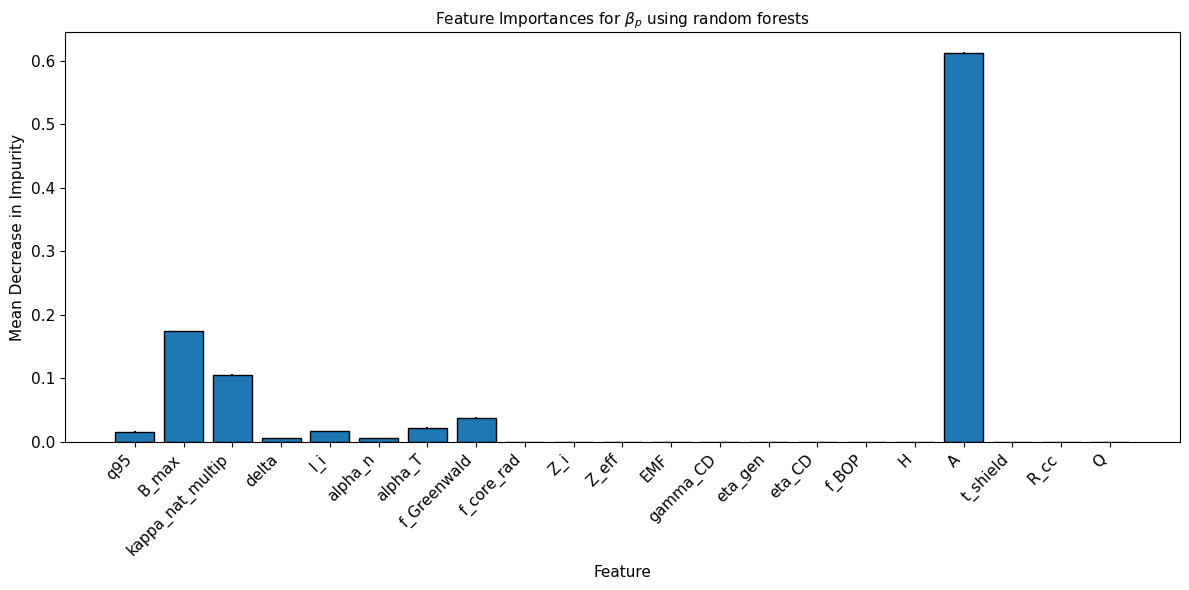

In [9]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bar chart with error bars
ax.bar(feature_names, importances, yerr=std, align='center', edgecolor='black')

# Title and labels with fontsize=11
ax.set_title(r"Feature Importances for $\beta_p$ using random forests", fontsize=11)
ax.set_xlabel("Feature", fontsize=11)
ax.set_ylabel("Mean Decrease in Impurity", fontsize=11)

# Put tick marks inside; set tick label size to 11
ax.tick_params(axis='both', which='both', direction='out', labelsize=11)

# Rotate x-axis tick labels if needed
plt.xticks(rotation=45, ha='right')

# Tight layout for clean spacing
fig.tight_layout()

# Save figure (adjust dpi/file name as needed)
plt.savefig("all_feature_importances.png", dpi=300)

# Show plot
plt.show()


Changing the dataset generation to focus on the variable features, keeping the rest fixed. Testing 3 values for each feature 3^9 = 19,683 rows.

In [53]:
all_params = {
    'q95': (11.5, 13.0),            # variable safety factor 
    'B_max': (1.2, 1.8),            # variable Maximum magnetic field on inboard TF coil 
    'kappa_nat_multip': (2.5, 3.1), # variable natural plasma elongation
    'delta': (0.3,0.4),             # variable triangularity
    'l_i': (0.7,1),                 # variable internal inductance
    'alpha_n': (0.1,2.0),           # variable density profile peaking factor
    'alpha_T': (1.5,2.0),           # variable Temperature Peaking Factor
    'f_Greenwald': (1.0,1.2),       # variable  Greenwald fraction
    'f_core_rad': 0.35,             # fixed core Radiation Fraction
    'Z_i': 13.0,                    # fixed  Ion Charge Number 
    'Z_eff': 1.8,                   # fixed  Effective Plasma Charge State
    'EMF': 1.3,                     # fixed neutron Energy Multiplication Factor
    'gamma_CD': 0.18,               # fixed  current drive efficiency factor
    'eta_gen': 0.36,                # fixed.  Power Conversion Efficiency
    'eta_CD': 0.4,                  # fixed Current Drive Efficiency
    'f_BOP': 0.25,                  # fixed  Balance of Plant Efficiency Factor. fraction of generated electricity required for the BoP Balance of Plant (BoP)  Here BoP is taken to mean all the recycled power required for reactor operation
    'H': 1.0,                       # fixed Energy Confinement Enhancement Factor
    'A': (1.6,1.8),                 # variable from paper
    't_shield': 0.0114,             # fixed shield thickness
    'R_cc': 0.3,                    # fixed Radius of leg of inboard TF coil vault
    'Q': 20                         # fixed reactor Q value. Fusion Gain Factor
}

def sample_param(value, n_points=3):
    """
    Return sample values for a parameter using np.linspace.
    If value is a tuple, use its first two elements as the start and end.
    Otherwise, return [value].
    """
    if isinstance(value, tuple):
        start, end = value[0], value[1]
        return np.linspace(start, end, n_points)
    else:
        return [value]

def generate_dataset(all_params, n_points_fixed=3):
    """
    Generate a reproducible dataset by sampling every key with a tuple value using np.linspace.
    This produces 3^(# of keys with tuple values) datapoints.
    Then, for each complete set of inputs, calculate reactor outputs using calculate_reactor_parameters.
    The final DataFrame contains the input features (all values in all_params) and target value beta_P.
    """
    # Building a dictionary mapping each key to its sample list
    samples = {key: sample_param(val, n_points_fixed) for key, val in all_params.items()}
    
    # All keys provided as tuples are variable
    variable_keys = [k for k, v in samples.items() if len(v) > 1]
    constant_keys = [k for k, v in samples.items() if len(v) == 1]
    
    # Creating a grid for variable keys
    grid_list = list(product(*(samples[k] for k in variable_keys)))
    
    data = []
    for vals in grid_list:
        sample = {}
        # Assign variable parameters
        for key, val in zip(variable_keys, vals):
            sample[key] = val
        # Assign constant parameters
        for key in constant_keys:
            sample[key] = samples[key][0]
            
        # Calculate reactor outputs
        try:
            calc_results = calculate_reactor_parameters(sample['R_cc'], sample['B_max'], sample['Q'], sample)
        except Exception as e:
            calc_results = {}
            print(f"Error calculating reactor parameters for sample {sample}: {e}")
        sample.update(calc_results)
        # Ensure beta_P is present
        if 'beta_P' not in sample:
            sample['beta_P'] = np.nan
        data.append(sample)
    
    df = pd.DataFrame(data)
    # Use all keys in all_params as input features.
    feature_columns = list(all_params.keys())
    df = df[feature_columns + ['beta_P']]
    return df

# Generate the dataset.
optimized_data = generate_dataset(all_params, n_points_fixed=3)
print("Dataset shape:", optimized_data.shape)  # Should be 3^9 = 19,683 rows
display(optimized_data)

Dataset shape: (19683, 22)


,q95,B_max,kappa_nat_multip,delta,l_i,alpha_n,alpha_T,f_Greenwald,f_core_rad,Z_i,...,gamma_CD,eta_gen,eta_CD,f_BOP,H,A,t_shield,R_cc,Q,beta_P
0,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.6,0.0114,0.3,20,5.879695
1,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.7,0.0114,0.3,20,6.787627
2,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.0,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.8,0.0114,0.3,20,7.894542
3,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.1,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.6,0.0114,0.3,20,6.467664
4,11.5,1.2,2.5,0.3,0.7,0.1,1.5,1.1,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.7,0.0114,0.3,20,7.466390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19678,13.0,1.8,3.1,0.4,1.0,2.0,2.0,1.1,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.7,0.0114,0.3,20,4.306788
19679,13.0,1.8,3.1,0.4,1.0,2.0,2.0,1.1,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.8,0.0114,0.3,20,4.875105
19680,13.0,1.8,3.1,0.4,1.0,2.0,2.0,1.2,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.6,0.0114,0.3,20,4.158432
19681,13.0,1.8,3.1,0.4,1.0,2.0,2.0,1.2,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.7,0.0114,0.3,20,4.698314


Max beta_P: 12.053844798444798
Mean beta_P: 5.792808513834451
Min beta_P: 2.938455068290611


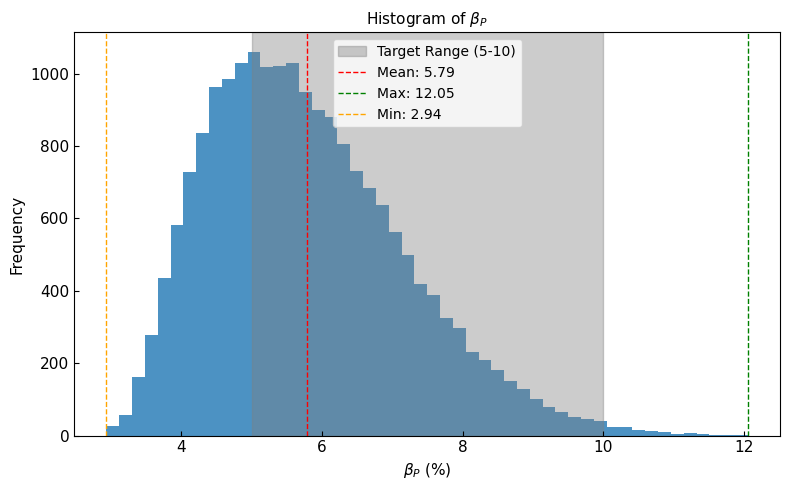

In [54]:
# Remove NaNs from target column (just in case if they appear)
data = optimized_data.dropna(subset=['beta_P'])

# Summary stats
betaP_max = data.beta_P.max()
betaP_mean = data.beta_P.mean()
betaP_min = data.beta_P.min()

print("Max beta_P:", betaP_max)
print("Mean beta_P:", betaP_mean)
print("Min beta_P:", betaP_min)

# Create histogram plot
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(data.beta_P, bins=50, alpha=0.8)

# Label and styling
plt.xlabel(r"$\beta_P$ (%)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.tick_params(axis='both', labelsize=11, direction='in')
plt.title(r"Histogram of $\beta_P$", fontsize=11)

# Add shaded region for target beta_P range
plt.axvspan(5, 10, color='grey', alpha=0.4, label="Target Range (5-10)")

# Overlay vertical lines for stats
plt.axvline(betaP_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {betaP_mean:.2f}')
plt.axvline(betaP_max, color='green', linestyle='dashed', linewidth=1, label=f'Max: {betaP_max:.2f}')
plt.axvline(betaP_min, color='orange', linestyle='dashed', linewidth=1, label=f'Min: {betaP_min:.2f}')

plt.legend()

# Save the figure before showing
plt.tight_layout()
plt.savefig("beta_P_histogram.png", dpi=300, format='png')

# Display the plot
plt.show()


## Training random forests and gradient boosted models

In [55]:
# Define features and target variable
X = optimized_data.drop(columns=['beta_P'])  # Features (reactor parameters)
y = optimized_data['beta_P']  # Target (beta_P)

# Split dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)


Cross validation to find the best configuration of hyperparameters

In [ ]:
# For RandomForestRegressor
rf_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'max_features': [2, 4, 6, 8, 9]
}

# For GradientBoostingRegressor
gb_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'max_features': [2, 4, 6, 8, 9],
    'learning_rate': [0.05, 0.1, 0.2]
}

cv_folds = 5  # Using 5 different splits for training/validation

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=42),
    param_grid=rf_param_grid,
    cv=cv_folds,
    scoring='neg_mean_absolute_percentage_error',  # maximizing the negative MAPE
    verbose=1,
    n_jobs=-1
)

print("Starting grid search for Random Forest...")
rf_grid_search.fit(X_train, y_train)

print("\nRandom Forest Best Parameters:", rf_grid_search.best_params_)
print("Random Forest Best CV MAPE: {:.2f}%".format(-rf_grid_search.best_score_))

gb_grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(n_estimators=1000, loss='squared_error', random_state=42),
    param_grid=gb_param_grid,
    cv=cv_folds,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1
)

print("\nStarting grid search for Gradient Boosting...")
gb_grid_search.fit(X_train, y_train)

print("\nGradient Boosting Best Parameters:", gb_grid_search.best_params_)
print("Gradient Boosting Best CV MAPE: {:.2f}%".format(-gb_grid_search.best_score_))

Starting grid search for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Random Forest Best Parameters: {'max_depth': 20, 'max_features': 9}
Random Forest Best CV MAPE: 0.01%

Starting grid search for Gradient Boosting...
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Gradient Boosting Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 9}
Gradient Boosting Best CV MAPE: 0.00%


Training models using the best configuration.

In [47]:
# Define models
rf_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                  max_depth=20, max_features=9, random_state=42)
gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05,
                                     n_estimators=1000, max_depth=5, max_features=9,
                                     random_state=42)

# Train the models
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

# Compute Mean Absolute Percentage Error (MAPE)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions) * 100
gb_mape = mean_absolute_percentage_error(y_test, gb_predictions) * 100

# Display results
model_results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting"],
    "MAPE (%)": [rf_mape, gb_mape],
})

print("ML Model Performance Results:")
print(model_results)

ML Model Performance Results:
               Model  MAPE (%)
0      Random Forest  0.982346
1  Gradient Boosting  0.278496


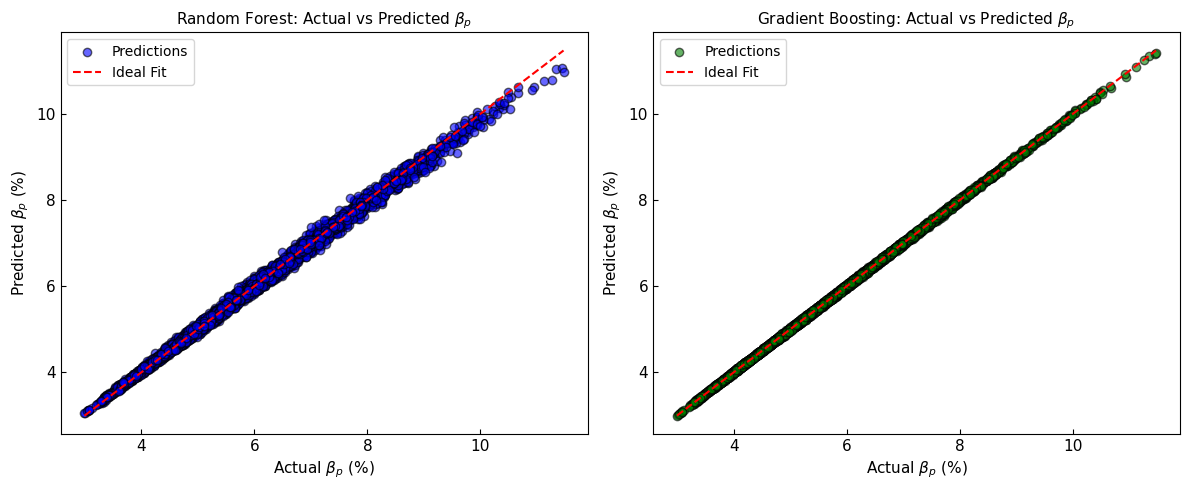

In [48]:
# Scatter Plot: Actual vs Predicted β_P
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Random Forest predictions
axes[0].scatter(y_test, rf_predictions, alpha=0.6, color='blue', edgecolor='k', label='Predictions')
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Fit')
axes[0].set_title("Random Forest: Actual vs Predicted $β_p$", fontsize=11)
axes[0].set_xlabel("Actual $β_p$ (%)", fontsize=11)
axes[0].set_ylabel("Predicted $β_p$ (%)", fontsize=11)
axes[0].tick_params(axis='both', labelsize=11, direction='in')
axes[0].legend()

# Gradient Boosting predictions
axes[1].scatter(y_test, gb_predictions, alpha=0.6, color='green', edgecolor='k', label='Predictions')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Fit')
axes[1].set_title("Gradient Boosting: Actual vs Predicted $β_p$", fontsize=11)
axes[1].set_xlabel("Actual $β_p$ (%)", fontsize=11)
axes[1].set_ylabel("Predicted $β_p$ (%)", fontsize=11)
axes[1].tick_params(axis='both', labelsize=11, direction='in')
axes[1].legend()

plt.tight_layout()

# Save figure
plt.savefig("actual_vs_predicted_betaP_scatter.png", dpi=300)
plt.show()


In [ ]:
# Evaluate Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Evaluate Gradient Boosting
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Print Metrics RMSE, MAE, R^2
print(f"Random Forest      - RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")
print(f"Gradient Boosting  - RMSE: {gb_rmse:.4f}, MAE: {gb_mae:.4f}, R²: {gb_r2:.4f}")



Random Forest      - RMSE: 0.0785, MAE: 0.0579, R²: 0.9968
Gradient Boosting  - RMSE: 0.0205, MAE: 0.0160, R²: 0.9998


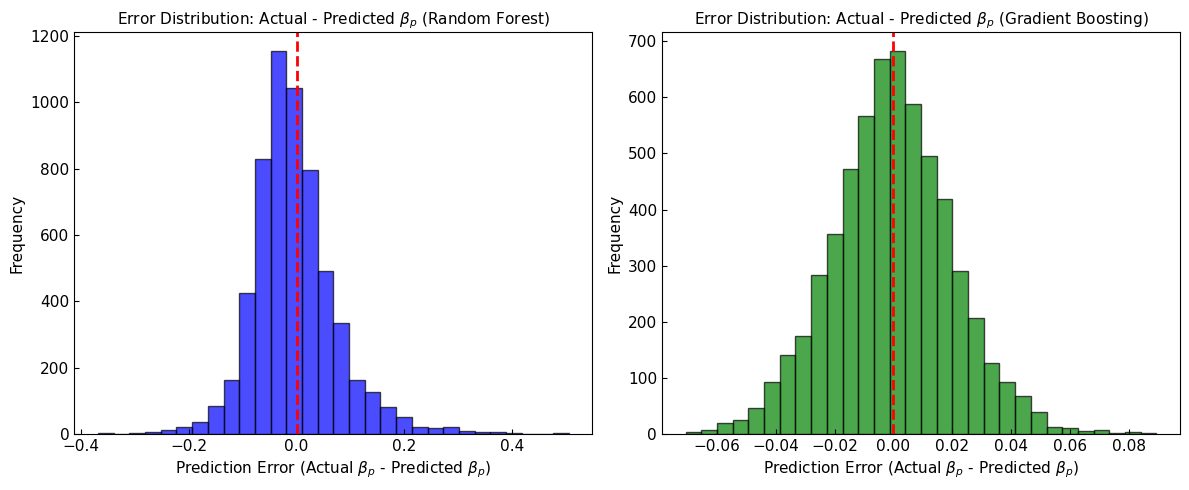

In [26]:
# Compute residuals 
rf_residuals = y_test - rf_predictions
gb_residuals = y_test - gb_predictions

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest residuals
axs[0].hist(rf_residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
axs[0].axvline(x=0, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title("Error Distribution: Actual - Predicted $β_p$ (Random Forest)", fontsize=11)
axs[0].set_xlabel("Prediction Error (Actual $β_p$ - Predicted $β_p$)", fontsize=11)
axs[0].set_ylabel("Frequency", fontsize=11)
axs[0].tick_params(axis='both', direction='in', labelsize=11)

# Gradient Boosting residuals
axs[1].hist(gb_residuals, bins=30, color='green', alpha=0.7, edgecolor='black')
axs[1].axvline(x=0, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title("Error Distribution: Actual - Predicted $β_p$ (Gradient Boosting)", fontsize=11)
axs[1].set_xlabel("Prediction Error (Actual $β_p$ - Predicted $β_p$)", fontsize=11)
axs[1].set_ylabel("Frequency", fontsize=11)
axs[1].tick_params(axis='both', direction='in', labelsize=11)

# Layout and Save
plt.tight_layout()
plt.savefig("residuals_histogram.png", dpi=300)
plt.show()

Individual tree predictions for random values of poloidal beta.

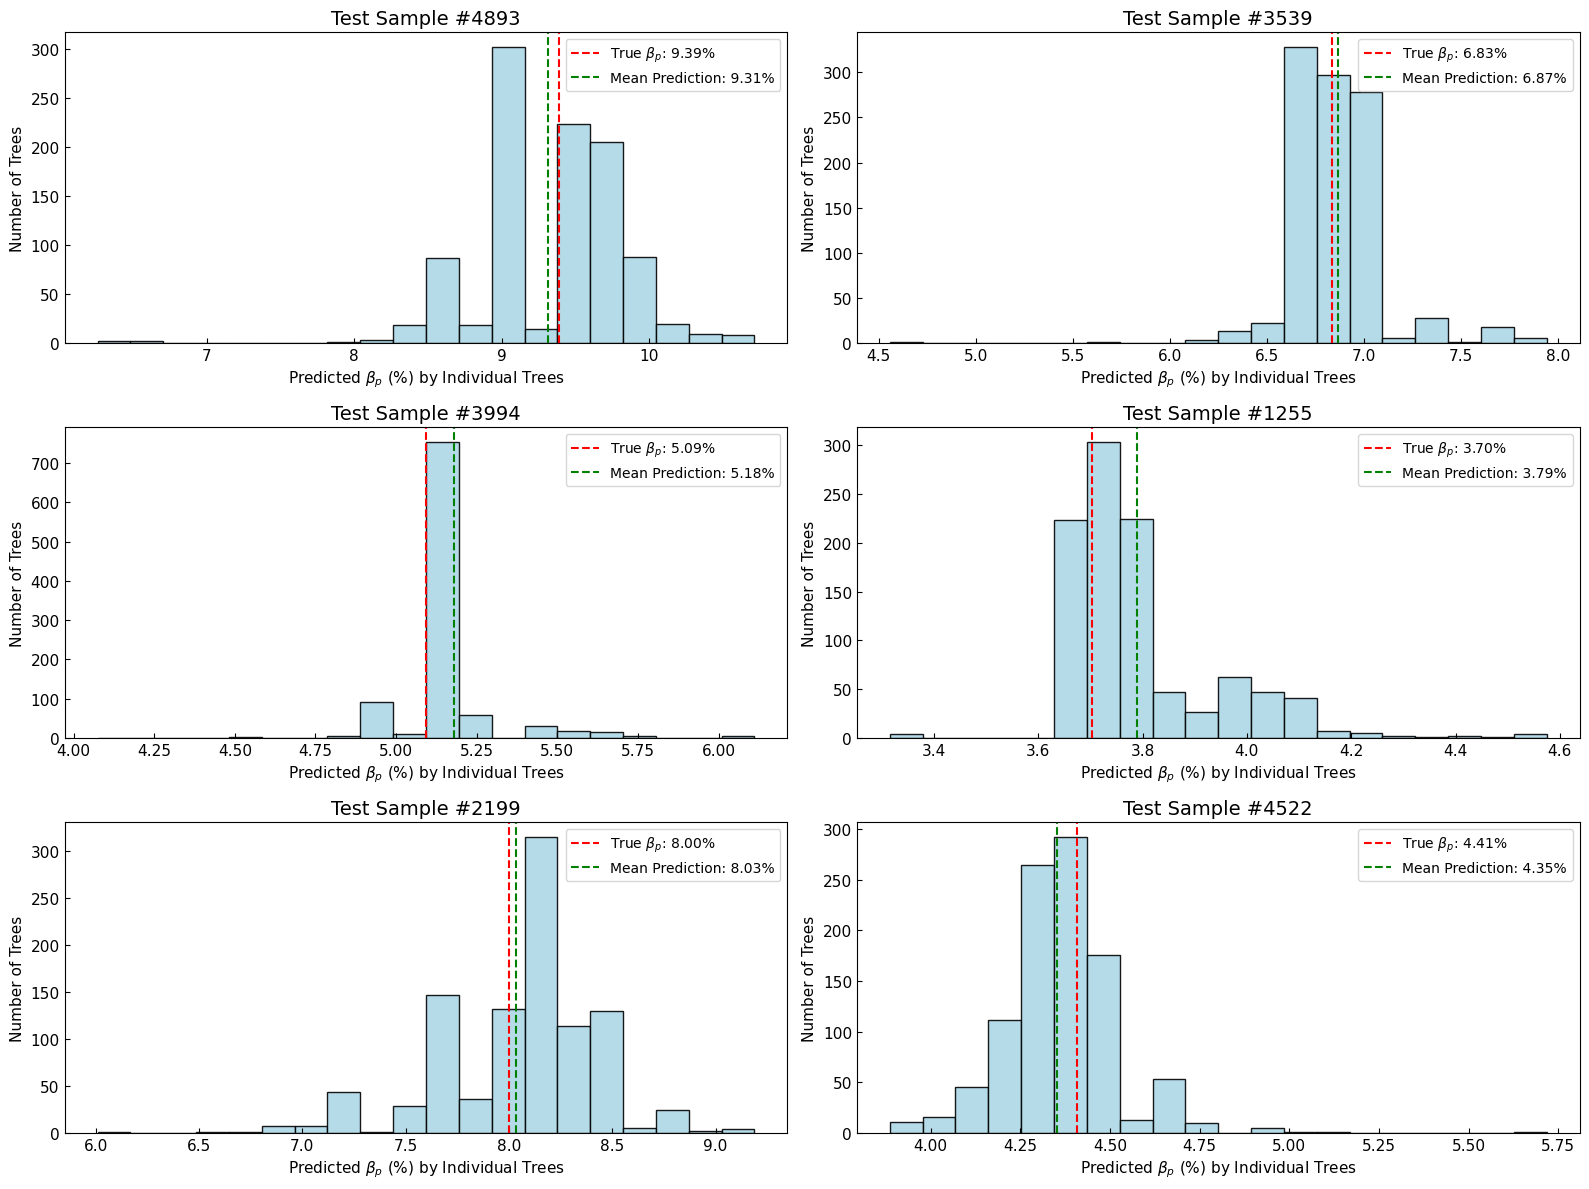

Figure saved as: tree_prediction_distribution_grid.png


In [ ]:
# Number of samples to plot
num_points_to_plot = 6
np.random.seed(56)
indices = np.random.choice(len(X_test), size=num_points_to_plot, replace=False)

# Create a figure with 3 rows x 2 columns of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

# Loop over the selected sample indices and plot each histogram in a subplot
for i, idx in enumerate(indices):
    ax = axes.flat[i]
    x_single = X_test.iloc[[idx]]
    true_beta = y_test.iloc[idx]
    
    # Get predictions from each tree in the ensemble
    tree_preds = []
    for tree in rf_model.estimators_:
        pred = tree.predict(x_single)[0]
        tree_preds.append(pred)
    tree_preds = np.array(tree_preds)
    
    # Compute the mean prediction
    mean_pred = tree_preds.mean()
    
    # Plot histogram of the tree predictions
    ax.hist(tree_preds, bins=20, color='lightblue', edgecolor='black', alpha=0.9)
    
    # Add vertical lines for true and mean predictions
    ax.axvline(true_beta, color='red', linestyle='dashed', linewidth=1.5, 
               label=f"True $β_p$: {true_beta:.2f}%")
    ax.axvline(mean_pred, color='green', linestyle='dashed', linewidth=1.5, 
               label=f"Mean Prediction: {mean_pred:.2f}%")
    
    ax.set_xlabel("Predicted $β_p$ (%) by Individual Trees", fontsize=11)
    ax.set_ylabel("Number of Trees", fontsize=11)
    ax.set_title(f"Test Sample #{idx}", fontsize=14)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=11)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("tree_prediction_distribution_grid.png", dpi=300)
plt.show()

print("Figure saved as: tree_prediction_distribution_grid.png")


Do the same, but for the median values, as that is more representative for this dataset.

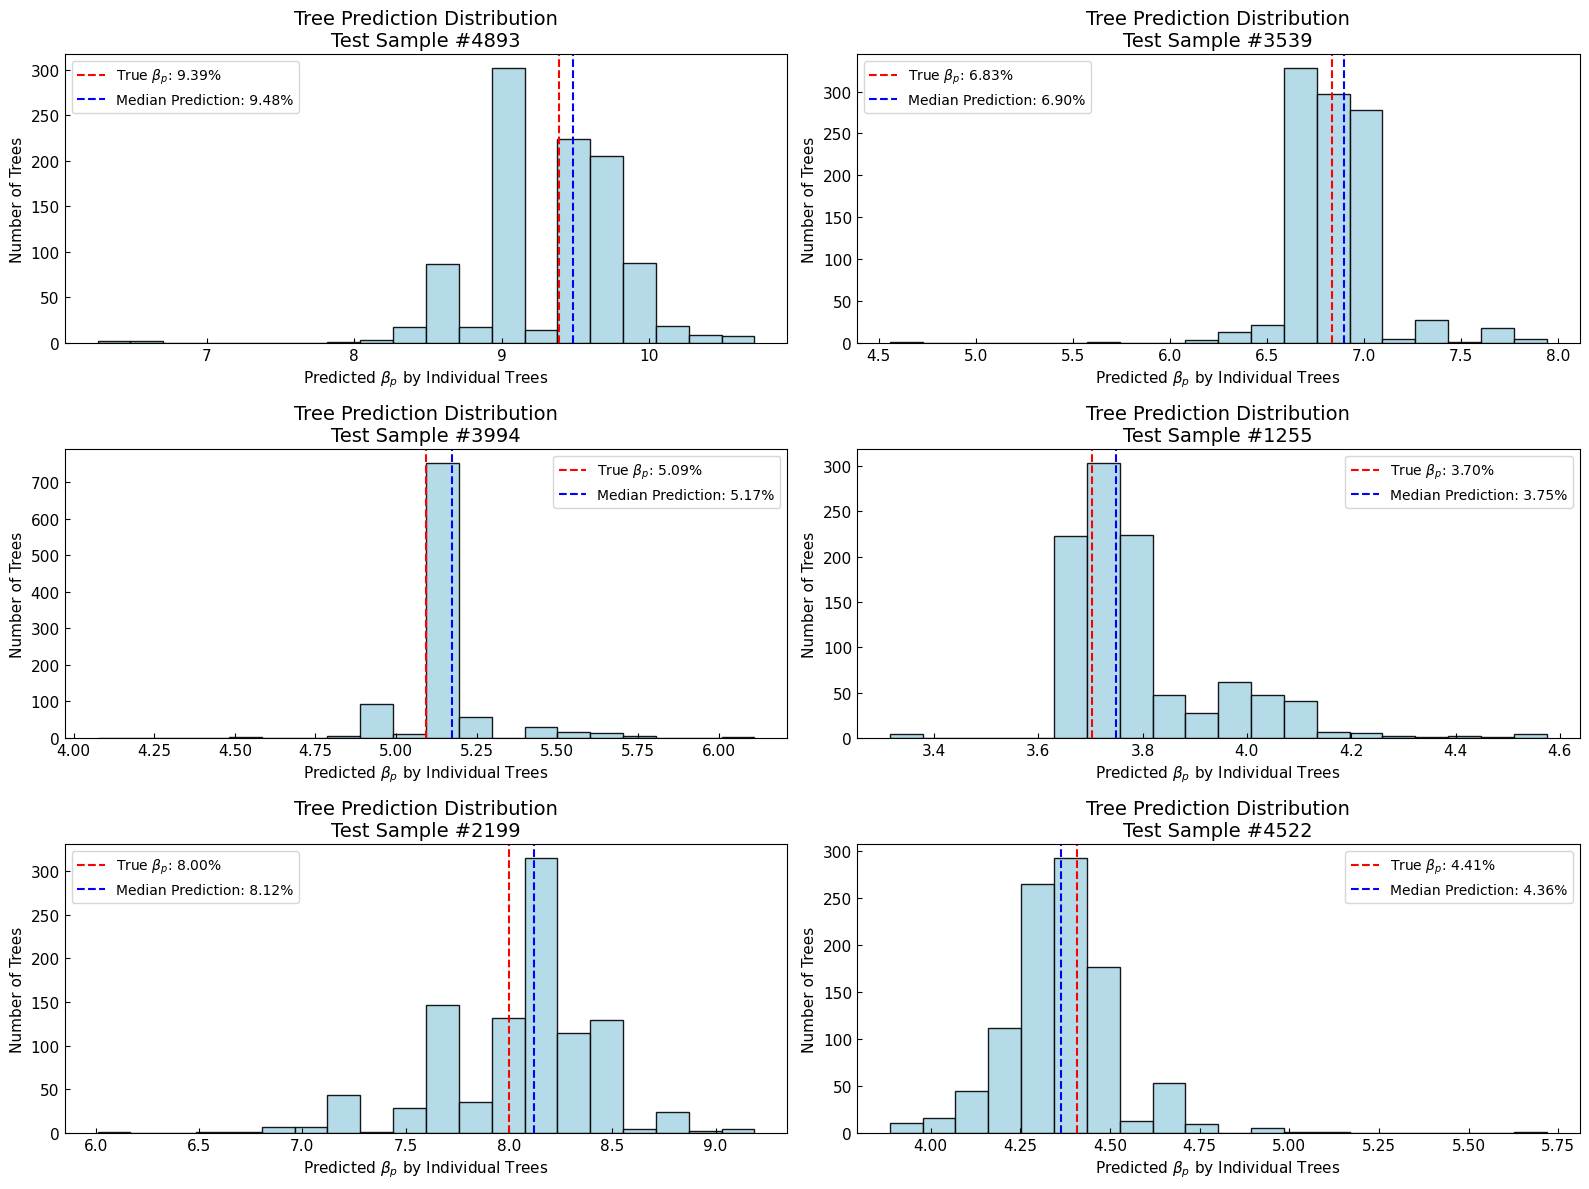

Figure saved as: tree_median_prediction_grid.png


In [ ]:
num_points_to_plot = 6
np.random.seed(56)
indices = np.random.choice(len(X_test), size=num_points_to_plot, replace=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

for i, idx in enumerate(indices):
    ax = axes.flat[i]
    x_single = X_test.iloc[[idx]] 
    true_beta = y_test.iloc[idx]
    
    # Get predictions from each tree in the RF ensemble
    tree_preds = []
    for tree in rf_model.estimators_:
        pred = tree.predict(x_single)[0]
        tree_preds.append(pred)
    tree_preds = np.array(tree_preds)
    
    # Compute the median prediction from the trees
    median_pred = np.median(tree_preds)
    
    # Plot histogram of the tree predictions
    ax.hist(tree_preds, bins=20, color='lightblue', edgecolor='black', alpha=0.9)
    
    # Add vertical lines for true beta and median prediction
    ax.axvline(true_beta, color='red', linestyle='dashed', linewidth=1.5, label=f"True $β_p$: {true_beta:.2f}%")
    ax.axvline(median_pred, color='blue', linestyle='dashed', linewidth=1.5, label=f"Median Prediction: {median_pred:.2f}%")
    
    ax.set_xlabel("Predicted $β_p$ by Individual Trees", fontsize=11)
    ax.set_ylabel("Number of Trees", fontsize=11)
    ax.set_title(f"Tree Prediction Distribution\nTest Sample #{idx}", fontsize=14)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=11)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("tree_median_prediction_grid.png", dpi=300)
plt.show()

print("Figure saved as: tree_median_prediction_grid.png")


In [33]:
# Check to see the number of trees in the Random Forest ensemble
num_trees = len(rf_model.estimators_)
print("Number of trees in the ensemble:", num_trees)

Number of trees in the ensemble: 1000


## Impurity Based Feature Importance

Plotting for all input values to see which features vary


Feature Importance - Random Forest:
             Feature  Importance
1              B_max    0.480730
17                 A    0.225399
7        f_Greenwald    0.100006
2   kappa_nat_multip    0.084552
6            alpha_T    0.055898
5            alpha_n    0.020578
4                l_i    0.015643
0                q95    0.011050
3              delta    0.006143
14            eta_CD    0.000000
19              R_cc    0.000000
18          t_shield    0.000000
16                 H    0.000000
15             f_BOP    0.000000
10             Z_eff    0.000000
13           eta_gen    0.000000
12          gamma_CD    0.000000
11               EMF    0.000000
9                Z_i    0.000000
8         f_core_rad    0.000000
20                 Q    0.000000

Feature Importance - Gradient Boosting:
             Feature  Importance
1              B_max    0.481963
17                 A    0.228084
7        f_Greenwald    0.101548
2   kappa_nat_multip    0.086966
6            alpha_T    0.05600

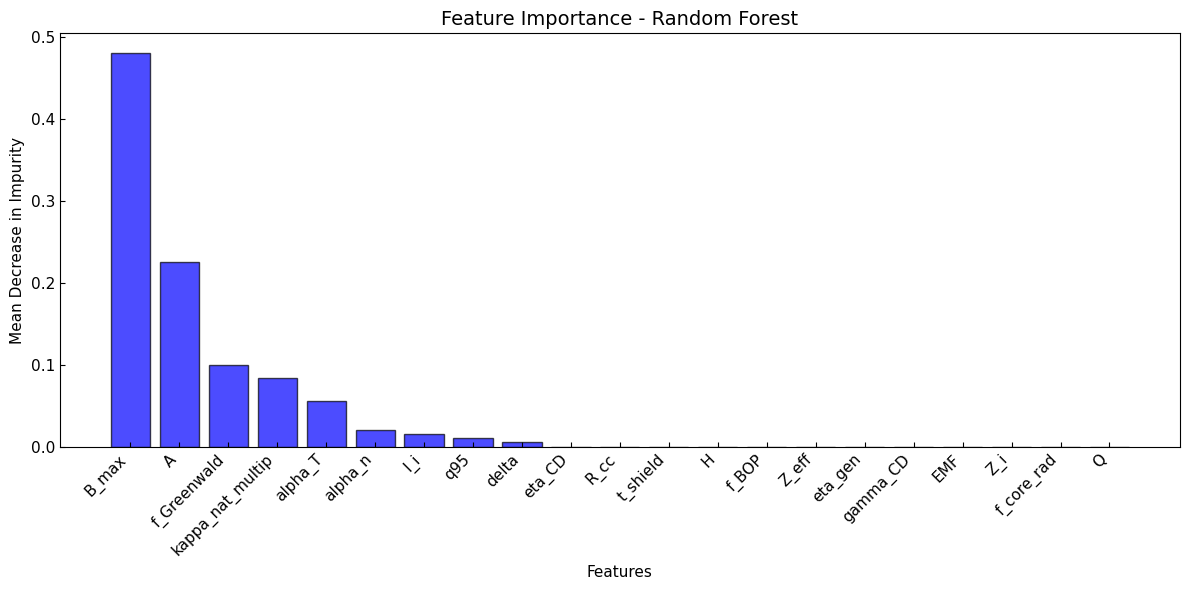

Saved: feature_importance_rf.png


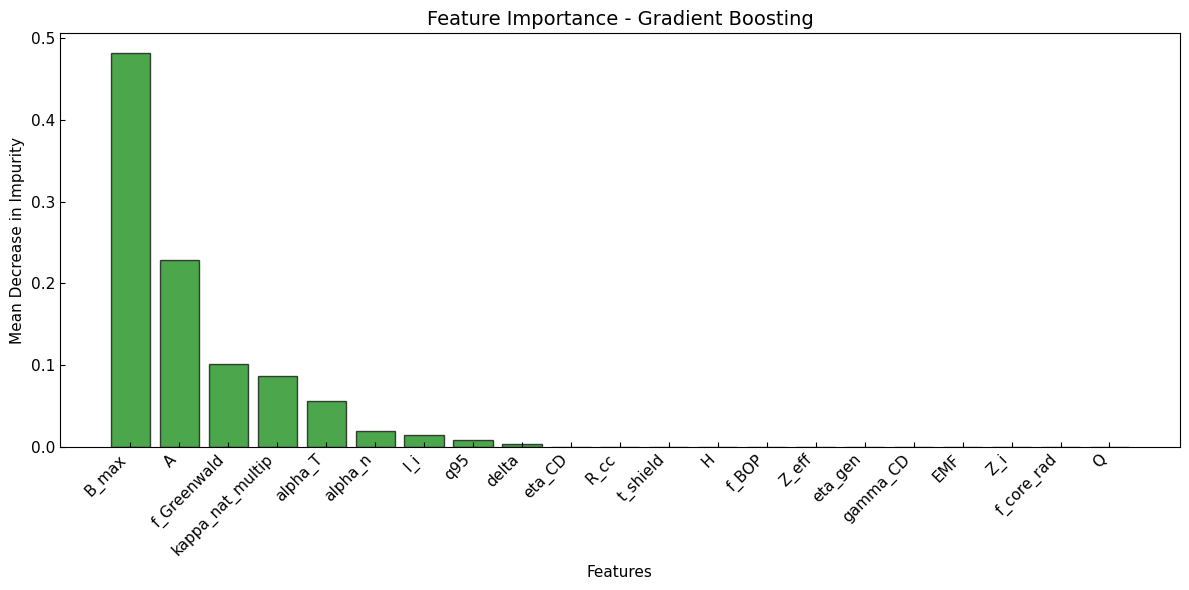

Saved: feature_importance_gb.png


In [35]:
# Feature Importance for Random Forest
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance - Random Forest:")
print(rf_importance)

# Feature Importance for Gradient Boosting
gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance - Gradient Boosting:")
print(gb_importance)

# Plotting Feature Importance for Random Forest
plt.figure(figsize=(12, 6))
plt.bar(rf_importance['Feature'], rf_importance['Importance'], color='blue', alpha=0.7, edgecolor='black')
plt.title("Feature Importance - Random Forest", fontsize=14)
plt.xlabel("Features", fontsize=11)
plt.ylabel("Mean Decrease in Impurity", fontsize=11)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_rf.png", dpi=300)
plt.show()
print("Saved: feature_importance_rf.png")

# Plot Feature Importance for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.bar(gb_importance['Feature'], gb_importance['Importance'], color='green', alpha=0.7, edgecolor='black')
plt.title("Feature Importance - Gradient Boosting", fontsize=14)
plt.xlabel("Features", fontsize=11)
plt.ylabel("Mean Decrease in Impurity", fontsize=11)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_gb.png", dpi=300)
plt.show()
print("Saved: feature_importance_gb.png")


Plotting the variable features only


Feature Importance - Random Forest:
            Feature  Importance
3             delta    0.006143
0               q95    0.011050
4               l_i    0.015643
5           alpha_n    0.020578
6           alpha_T    0.055898
2  kappa_nat_multip    0.084552
7       f_Greenwald    0.100006
8                 A    0.225399
1             B_max    0.480730

Feature Importance - Gradient Boosting:
            Feature  Importance
3             delta    0.003071
0               q95    0.008442
4               l_i    0.014122
5           alpha_n    0.019795
6           alpha_T    0.056009
2  kappa_nat_multip    0.086966
7       f_Greenwald    0.101548
8                 A    0.228084
1             B_max    0.481963


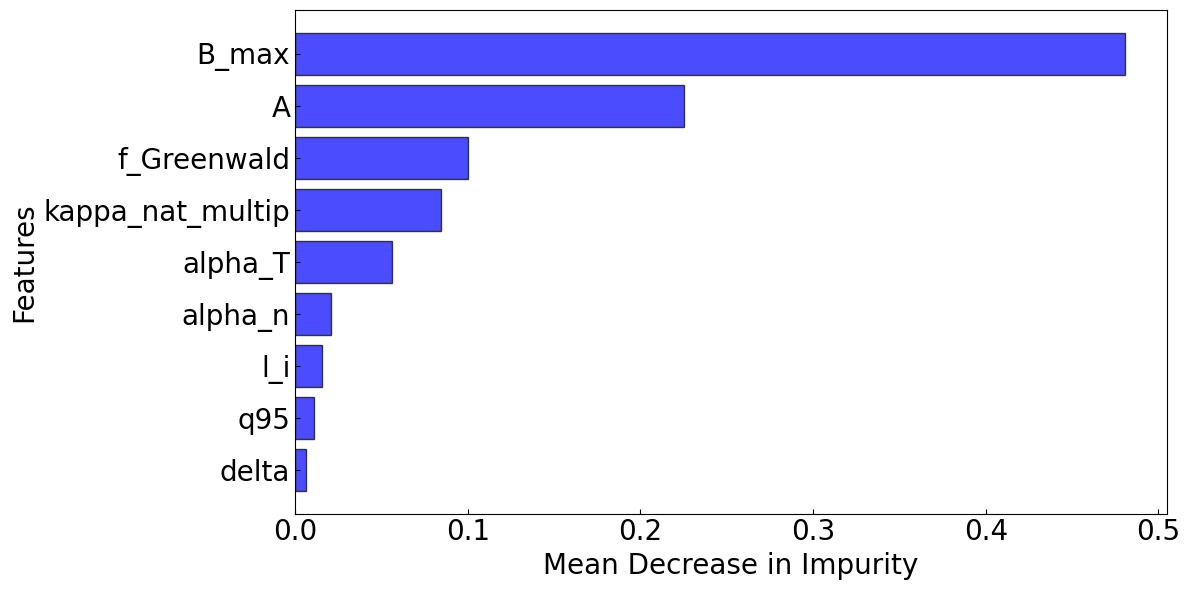

Saved: feature_importance_rf_variable_full.png


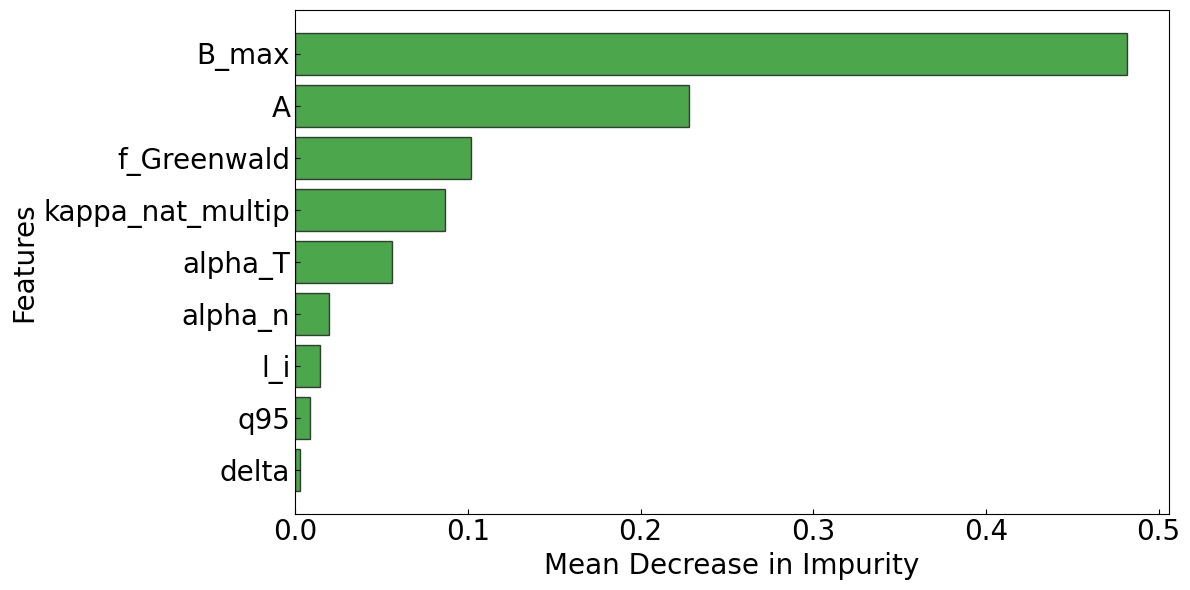

Saved: feature_importance_gb_variable_full.png


In [8]:
# Filter X to only include features that have more than one unique value.
X_variable = X.loc[:, X.nunique() > 1]

# Recompute feature importances for the variable features only.
rf_importance = pd.DataFrame({
    'Feature': X_variable.columns,
    'Importance': rf_model.feature_importances_[[X.columns.get_loc(col) for col in X_variable.columns]]
}).sort_values(by='Importance', ascending=True)  # sort ascending for horizontal bar plot

gb_importance = pd.DataFrame({
    'Feature': X_variable.columns,
    'Importance': gb_model.feature_importances_[[X.columns.get_loc(col) for col in X_variable.columns]]
}).sort_values(by='Importance', ascending=True)

print("\nFeature Importance - Random Forest:")
print(rf_importance)

print("\nFeature Importance - Gradient Boosting:")
print(gb_importance)

# Plot for Random Forest using horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='blue', alpha=0.7, edgecolor='black')
#plt.title("Feature Importance - Random Forest", fontsize=20)
plt.xlabel("Mean Decrease in Impurity", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_rf_variable_full.png", dpi=300)
plt.show()
print("Saved: feature_importance_rf_variable_full.png")

# Plot for Gradient Boosting using horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(gb_importance['Feature'], gb_importance['Importance'], color='green', alpha=0.7, edgecolor='black')
#plt.title("Feature Importance - Gradient Boosting", fontsize=20)
plt.xlabel("Mean Decrease in Impurity", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_gb_variable_full.png", dpi=300)
plt.show()
print("Saved: feature_importance_gb_variable_full.png")



Feature Importance - Random Forest:
            Feature  Importance
1             B_max    0.480730
8                 A    0.225399
7       f_Greenwald    0.100006
2  kappa_nat_multip    0.084552
6           alpha_T    0.055898
5           alpha_n    0.020578
4               l_i    0.015643
0               q95    0.011050
3             delta    0.006143

Feature Importance - Gradient Boosting:
            Feature  Importance
1             B_max    0.481963
8                 A    0.228084
7       f_Greenwald    0.101548
2  kappa_nat_multip    0.086966
6           alpha_T    0.056009
5           alpha_n    0.019795
4               l_i    0.014122
0               q95    0.008442
3             delta    0.003071


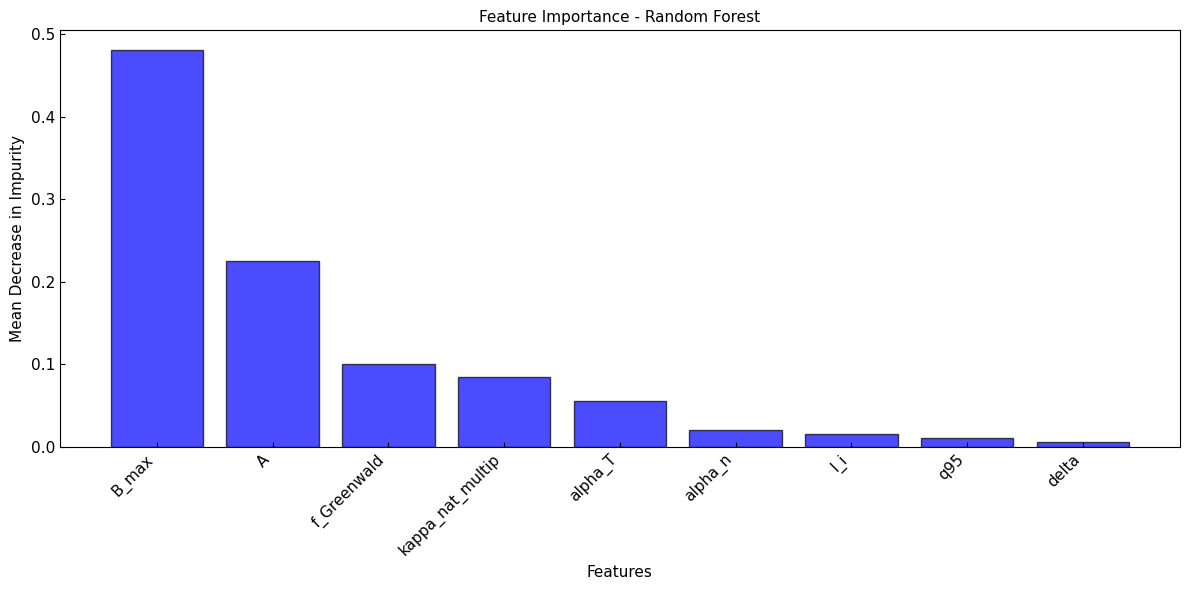

Saved: feature_importance_rf_variable_full.png


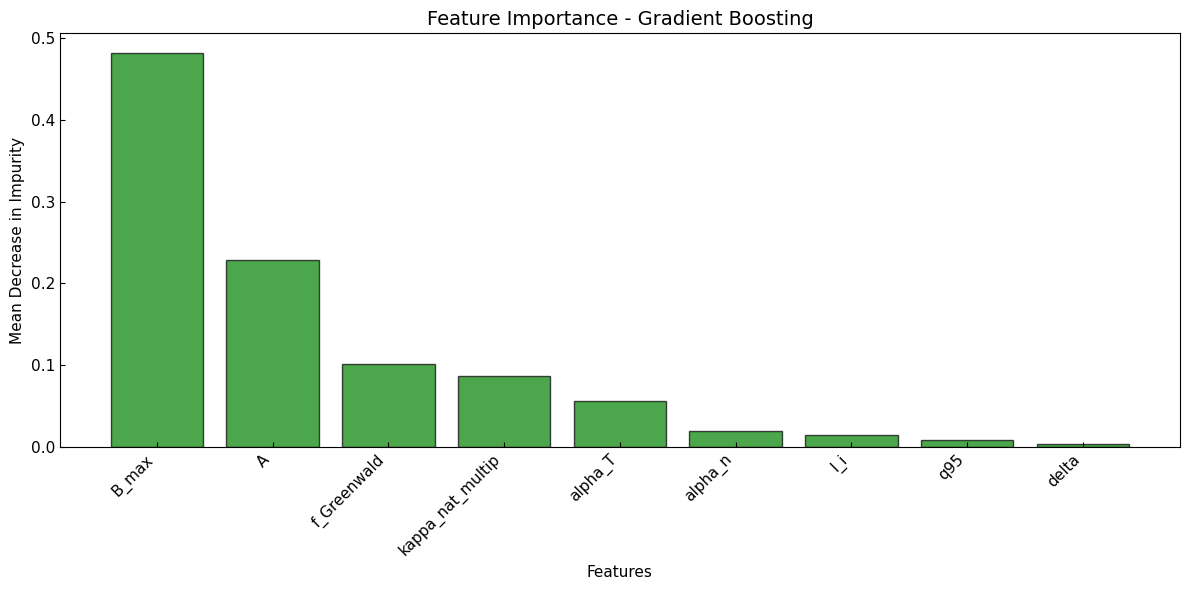

Saved: feature_importance_gb_variable_full.png


In [ ]:
# Filter X to only include features that have more than one unique value
X_variable = X.loc[:, X.nunique() > 1]

# Recompute feature importances using the variable features only
rf_importance = pd.DataFrame({
    'Feature': X_variable.columns,
    'Importance': rf_model.feature_importances_[[X.columns.get_loc(col) for col in X_variable.columns]]
}).sort_values(by='Importance', ascending=False)

gb_importance = pd.DataFrame({
    'Feature': X_variable.columns,
    'Importance': gb_model.feature_importances_[[X.columns.get_loc(col) for col in X_variable.columns]]
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance - Random Forest:")
print(rf_importance)

print("\nFeature Importance - Gradient Boosting:")
print(gb_importance)

# Plot for Random Forest
plt.figure(figsize=(12, 6))
plt.bar(rf_importance['Importance'], rf_importance['Feature'], color='blue', alpha=0.7, edgecolor='black')
plt.title("Feature Importance - Random Forest", fontsize=11)
plt.ylabel("Features", fontsize=11)
plt.xlabel("Mean Decrease in Impurity", fontsize=11)
plt.yticks(rotation=45, ha='right', fontsize=11)
plt.xticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_rf_variable_full.png", dpi=300)
plt.show()
print("Saved: feature_importance_rf_variable_full.png")

# Plot for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.bar(gb_importance['Importance'], gb_importance['Feature'], color='green', alpha=0.7, edgecolor='black')
plt.title("Feature Importance - Gradient Boosting", fontsize=14)
plt.ylabel("Features", fontsize=11)
plt.xlabel("Mean Decrease in Impurity", fontsize=11)
plt.yticks(rotation=45, ha='right', fontsize=11)
plt.xticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in')
plt.tight_layout()
plt.savefig("feature_importance_gb_variable_full.png", dpi=300)
plt.show()
print("Saved: feature_importance_gb_variable_full.png")


## Training an MLP Model

In [ ]:
# Define parameter grid for MLPRegressor
param_grid = {
    'alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001],
    'hidden_layer_sizes': [
        (20,20),
        (20, 20, 10), 
        (20, 20, 20), 
        (20, 20, 10, 10), 
        (20, 20, 20, 20), 
        (20, 20, 10, 10, 10), 
        (20, 20, 20, 20, 20), 

    ]
}

mlp = MLPRegressor(max_iter=1000, solver='adam', random_state=42)

# Set up GridSearchCV to find the best hyperparameter configuration
grid_search = GridSearchCV(
    mlp, 
    param_grid, 
    cv=7, 
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best MLP hyperparameters found:", best_params)


Best MLP hyperparameters found: {'alpha': 1e-06, 'hidden_layer_sizes': (20, 20, 10, 10)}


In [49]:
# Evaluate the best MLP model on the test set
mlp_model = MLPRegressor(hidden_layer_sizes=(20, 20, 10, 10), max_iter=1000, solver='adam', alpha=1e-6, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

# Compute metrics
mlp_test_mape = mean_absolute_percentage_error(y_test, mlp_pred) * 100
mlp_r2 = r2_score(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))

# Print results
print(f"MLP Test Set MAPE: {mlp_test_mape:.6f}%")
print(f"MLP Test Set R²: {mlp_r2:.4f}")
print(f"MLP Test Set MAE: {mlp_mae:.4f}")
print(f"MLP Test Set RMSE: {mlp_rmse:.4f}")

MLP Test Set MAPE: 1.756019%
MLP Test Set R²: 0.9913
MLP Test Set MAE: 0.0993
MLP Test Set RMSE: 0.1296


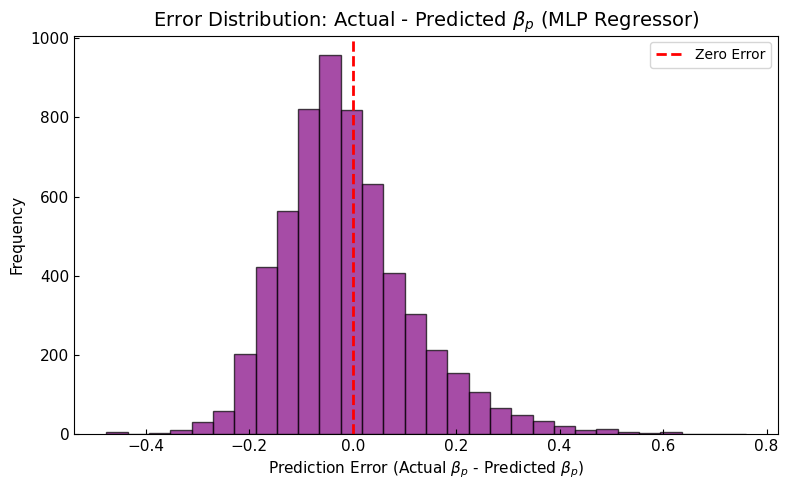

Saved: residuals_hist_mlp.png


In [44]:
# Compute residuals
mlp_residuals = y_test - mlp_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(mlp_residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2, label='Zero Error')

# Styling
plt.title("Error Distribution: Actual - Predicted $β_p$ (MLP Regressor)", fontsize=14)
plt.xlabel("Prediction Error (Actual $β_p$ - Predicted $β_p$)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in')
plt.legend()
plt.tight_layout()
plt.savefig("residuals_hist_mlp.png", dpi=300)
plt.show()

print("Saved: residuals_hist_mlp.png")


Histogram of MAPE for each model vs predicted beta_p

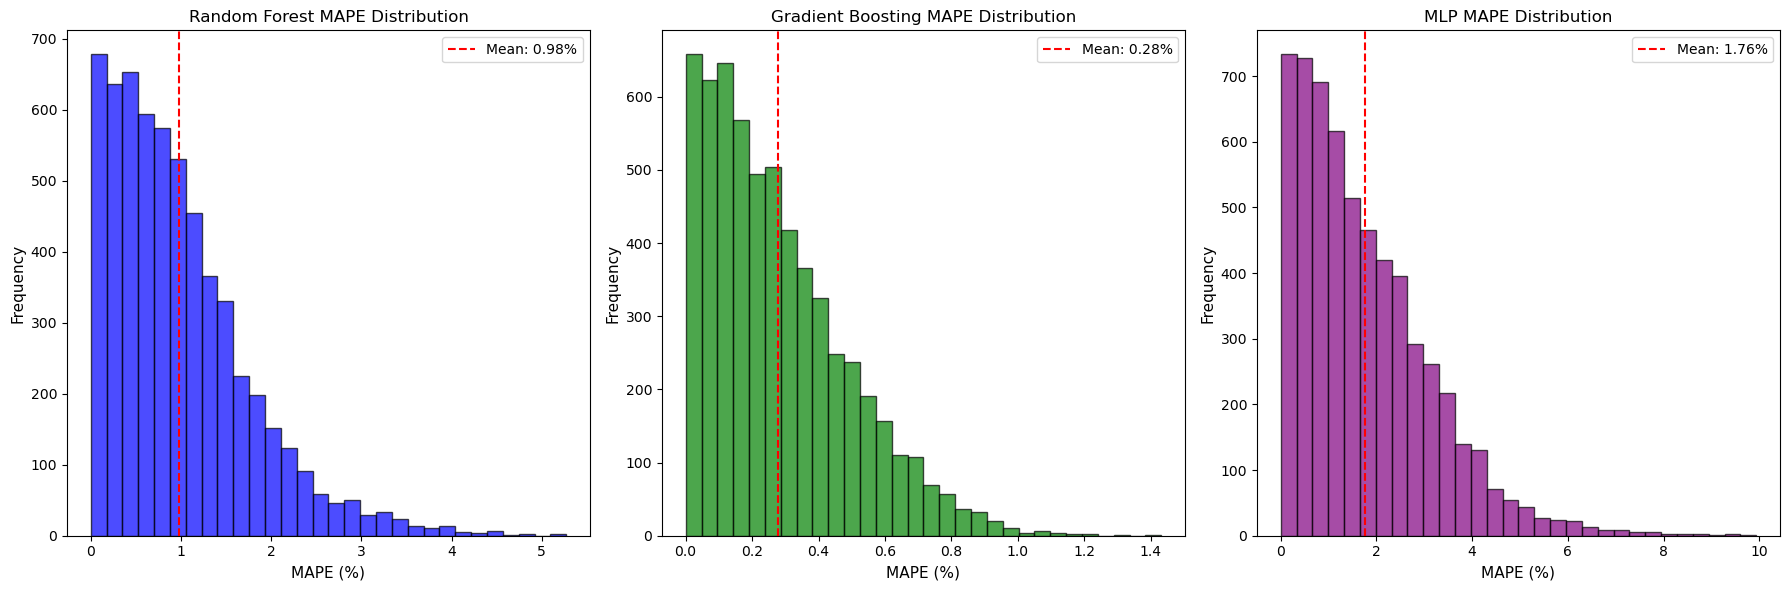

MAPE by beta_P range:


,beta_P_range,RF_MAPE (%),GB_MAPE (%),MLP_MAPE (%)
0,"(2.985, 3.841]",1.17,0.28,2.04
1,"(3.841, 4.688]",0.91,0.28,1.96
2,"(4.688, 5.536]",0.91,0.28,1.68
3,"(5.536, 6.384]",0.94,0.30,1.95
4,"(6.384, 7.232]",0.99,0.27,1.69
5,"(7.232, 8.079]",1.03,0.27,1.28
6,"(8.079, 8.927]",1.25,0.24,1.29
7,"(8.927, 9.775]",1.44,0.26,1.38
8,"(9.775, 10.622]",1.57,0.23,1.88
9,"(10.622, 11.47]",2.87,0.35,3.50


In [50]:
# Calculate residuals and MAPE for each prediction
results_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Predicted': rf_predictions,
    'GB_Predicted': gb_predictions,
    'MLP_Predicted': mlp_pred
})

# Calculate individual MAPE for each data point
results_df['RF_MAPE'] = np.abs((results_df['Actual'] - results_df['RF_Predicted']) / results_df['Actual']) * 100
results_df['GB_MAPE'] = np.abs((results_df['Actual'] - results_df['GB_Predicted']) / results_df['Actual']) * 100
results_df['MLP_MAPE'] = np.abs((results_df['Actual'] - results_df['MLP_Predicted']) / results_df['Actual']) * 100

# Create histograms of MAPE values for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest MAPE histogram
axes[0].hist(results_df['RF_MAPE'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Random Forest MAPE Distribution', fontsize=12)
axes[0].set_xlabel('MAPE (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].axvline(rf_mape, color='red', linestyle='--', label=f'Mean: {rf_mape:.2f}%')
axes[0].legend()

# Gradient Boosting MAPE histogram
axes[1].hist(results_df['GB_MAPE'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Gradient Boosting MAPE Distribution', fontsize=12)
axes[1].set_xlabel('MAPE (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].axvline(gb_mape, color='red', linestyle='--', label=f'Mean: {gb_mape:.2f}%')
axes[1].legend()

# MLP MAPE histogram
axes[2].hist(results_df['MLP_MAPE'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[2].set_title('MLP MAPE Distribution', fontsize=12)
axes[2].set_xlabel('MAPE (%)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].axvline(mlp_test_mape, color='red', linestyle='--', label=f'Mean: {mlp_test_mape:.2f}%')
axes[2].legend()

plt.tight_layout()
plt.savefig("mape_histograms.png", dpi=300)
plt.show()


# Print summary of MAPE by beta_P bin
print("MAPE by beta_P range:")
summary_table = pd.DataFrame({
    'beta_P_range': binned_mape['beta_P_bin'].astype(str),
    'RF_MAPE (%)': binned_mape['RF_MAPE'].round(2),
    'GB_MAPE (%)': binned_mape['GB_MAPE'].round(2),
    'MLP_MAPE (%)': binned_mape['MLP_MAPE'].round(2)
})
display(summary_table)

## Learning Curves

Plotting learning curves for RF, GB, and one MLP model.

In [46]:
# Learning curves using the following datapoints from the entire dataset
desired_datapoints = [19683, 17000, 15000, 13000, 10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 500]
performance_results = []

# Use the optimized_data for sampling
for total in desired_datapoints:
    print(f"\nUsing total datapoints = {total}...")
    if total < len(optimized_data):
        subset = optimized_data.sample(n=total, random_state=42)
    else:
        subset = optimized_data.copy()
    
    X = subset.drop(columns=['beta_P'])
    y = subset['beta_P']
    
    if len(X) < 2:
        rf_mape = np.nan
        gb_mape = np.nan
        mlp_mape = np.nan
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Train models
        rf_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                         max_depth=20, max_features=9, random_state=42)
        gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05,
                                             n_estimators=1000, max_depth=5, max_features=9,
                                             random_state=42)
        mlp_model = MLPRegressor(hidden_layer_sizes=(20,20,10,10), max_iter=1000,
                                 solver='adam', alpha=1e-6, random_state=42)
        
        rf_model.fit(X_train, y_train)
        gb_model.fit(X_train, y_train)
        mlp_model.fit(X_train, y_train)
        
        rf_pred = rf_model.predict(X_test)
        gb_pred = gb_model.predict(X_test)
        mlp_pred = mlp_model.predict(X_test)
        
        rf_mape = mean_absolute_percentage_error(y_test, rf_pred) * 100
        gb_mape = mean_absolute_percentage_error(y_test, gb_pred) * 100
        mlp_mape = mean_absolute_percentage_error(y_test, mlp_pred) * 100
        
    performance_results.append({
        'total_datapoints': total,
        'RF_MAPE': rf_mape,
        'GB_MAPE': gb_mape,
        'MLP_MAPE': mlp_mape
    })
    print(f"Total datapoints: {total} | RF MAPE: {rf_mape:.2f}% | GB MAPE: {gb_mape:.2f}% | MLP MAPE: {mlp_mape:.2f}%")

perf_df = pd.DataFrame(performance_results)
print("\nPerformance results:")
print(perf_df)


Using total datapoints = 19683...
Total datapoints: 19683 | RF MAPE: 0.98% | GB MAPE: 0.28% | MLP MAPE: 1.76%

Using total datapoints = 17000...
Total datapoints: 17000 | RF MAPE: 1.05% | GB MAPE: 0.28% | MLP MAPE: 1.77%

Using total datapoints = 15000...
Total datapoints: 15000 | RF MAPE: 1.16% | GB MAPE: 0.29% | MLP MAPE: 2.80%

Using total datapoints = 13000...
Total datapoints: 13000 | RF MAPE: 1.20% | GB MAPE: 0.31% | MLP MAPE: 1.81%

Using total datapoints = 10000...
Total datapoints: 10000 | RF MAPE: 1.38% | GB MAPE: 0.35% | MLP MAPE: 2.22%

Using total datapoints = 9000...
Total datapoints: 9000 | RF MAPE: 1.40% | GB MAPE: 0.36% | MLP MAPE: 2.74%

Using total datapoints = 8000...
Total datapoints: 8000 | RF MAPE: 1.49% | GB MAPE: 0.35% | MLP MAPE: 2.77%

Using total datapoints = 7000...
Total datapoints: 7000 | RF MAPE: 1.66% | GB MAPE: 0.39% | MLP MAPE: 2.35%

Using total datapoints = 6000...
Total datapoints: 6000 | RF MAPE: 1.64% | GB MAPE: 0.39% | MLP MAPE: 2.57%

Using to

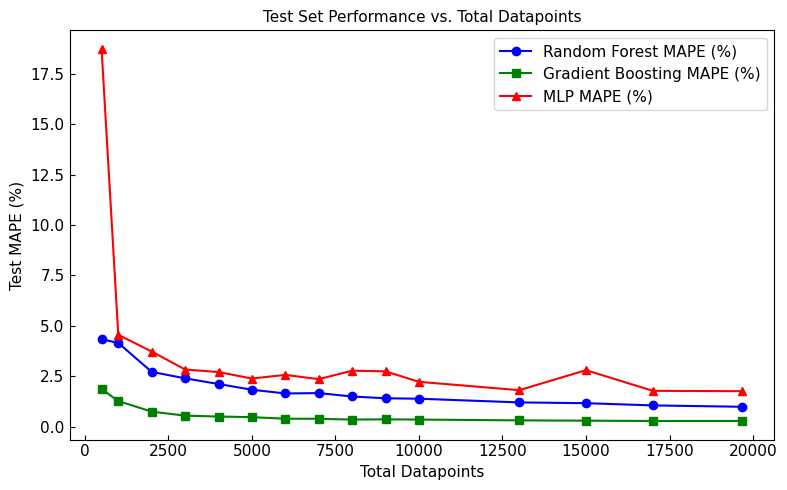

In [49]:
# Plot performance vs. total datapoints
plt.figure(figsize=(8,5))
plt.plot(perf_df['total_datapoints'], perf_df['RF_MAPE'], marker='o', label="Random Forest MAPE (%)", color='blue')
plt.plot(perf_df['total_datapoints'], perf_df['GB_MAPE'], marker='s', label="Gradient Boosting MAPE (%)", color='green')
plt.plot(perf_df['total_datapoints'], perf_df['MLP_MAPE'], marker='^', label="MLP MAPE (%)", color='red')
plt.xlabel("Total Datapoints", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Test Set Performance vs. Total Datapoints", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("performance_vs_datapoints.png", dpi=300)
plt.show()

Plotting RF and GB only

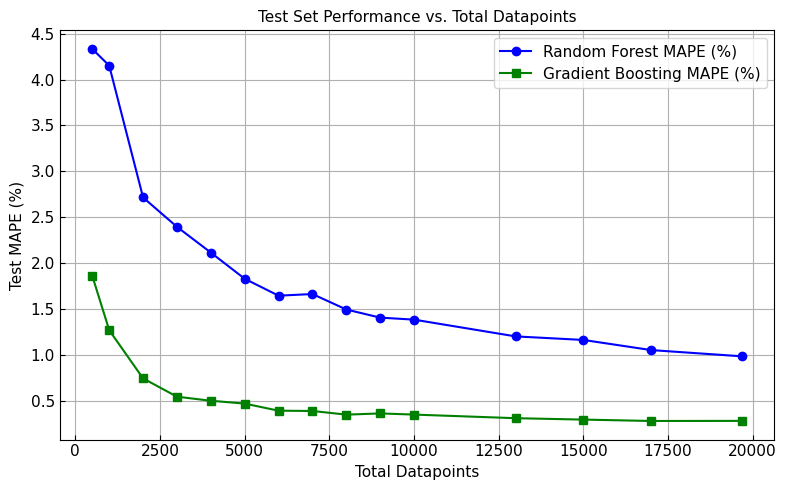

In [67]:
# Plot performance vs. total datapoints
plt.figure(figsize=(8,5))
plt.plot(perf_df['total_datapoints'], perf_df['RF_MAPE'], marker='o', label="Random Forest MAPE (%)", color='blue')
plt.plot(perf_df['total_datapoints'], perf_df['GB_MAPE'], marker='s', label="Gradient Boosting MAPE (%)", color='green')
plt.xlabel("Total Datapoints", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Test Set Performance vs. Total Datapoints", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', which='both', direction='in', labelsize=11)
plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.savefig("performance_vs_datapoints_RF_GB.png", dpi=300)
plt.show()

MAPE comparison:
RF: 0.982346%
GB: 0.278496%
MLP: 1.756019%


19,683 dps (full dataset)
GB is good with 2000 dps, still under 1% MAPE
RF is good with 5000 dps aswell 0.9% difference between original MAPE
MLP performs the worst compared to the two other models. It fluctuates a lot do to randomness. 

The next section averages 10 models for each method (RF, GB, and MLP) to account for randomness, and also adds errorbars using the 95% confidence interval.

In [50]:
# Averaged over 10 models for each method

# Using the optimized_data for sampling
for total in desired_datapoints:
    print(f"\nUsing total datapoints = {total}...")
    if total < len(optimized_data):
        subset = optimized_data.sample(n=total, random_state=42)
    else:
        subset = optimized_data.copy()
    
    X = subset.drop(columns=['beta_P'])
    y = subset['beta_P']
    
    if len(X) < 2:
        rf_mape_list = [np.nan]*10
        gb_mape_list = [np.nan]*10
        mlp_mape_list = [np.nan]*10
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # For RF, GB, and MLP, run 10 trials for each
        rf_mape_list = []
        gb_mape_list = []
        mlp_mape_list = []
        for i in range(10):
            rf_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                             max_depth=20, max_features=9, random_state=42+i)
            gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05,
                                                 n_estimators=1000, max_depth=5, max_features=9,
                                                 random_state=42+i)
            mlp_model = MLPRegressor(hidden_layer_sizes=(20,20,10,10), max_iter=1000, solver='adam',
                                     alpha=1e-6, random_state=42+i)
            rf_model.fit(X_train, y_train)
            gb_model.fit(X_train, y_train)
            mlp_model.fit(X_train, y_train)
            
            rf_pred = rf_model.predict(X_test)
            gb_pred = gb_model.predict(X_test)
            mlp_pred = mlp_model.predict(X_test)
            
            rf_mape_list.append(mean_absolute_percentage_error(y_test, rf_pred) * 100)
            gb_mape_list.append(mean_absolute_percentage_error(y_test, gb_pred) * 100)
            mlp_mape_list.append(mean_absolute_percentage_error(y_test, mlp_pred) * 100)
    
    # Compute mean and 95% confidence interval for each model
    def compute_stats(mape_list):
        mean_val = np.mean(mape_list)
        std_val = np.std(mape_list, ddof=1)
        ci_val = 1.96 * std_val / np.sqrt(len(mape_list))
        return mean_val, std_val, ci_val
    
    rf_mean, rf_std, rf_ci = compute_stats(rf_mape_list)
    gb_mean, gb_std, gb_ci = compute_stats(gb_mape_list)
    mlp_mean, mlp_std, mlp_ci = compute_stats(mlp_mape_list)
    
    performance_results.append({
        'total_datapoints': total,
        'RF_MAPE_mean': rf_mean,
        'RF_MAPE_std': rf_std,
        'RF_MAPE_CI': rf_ci,
        'GB_MAPE_mean': gb_mean,
        'GB_MAPE_std': gb_std,
        'GB_MAPE_CI': gb_ci,
        'MLP_MAPE_mean': mlp_mean,
        'MLP_MAPE_std': mlp_std,
        'MLP_MAPE_CI': mlp_ci
    })
    
    print(f"Total datapoints: {total} | RF MAPE: {rf_mean:.2f}% (±{rf_ci:.2f}) | GB MAPE: {gb_mean:.2f}% (±{gb_ci:.2f}) | MLP MAPE: {mlp_mean:.2f}% (±{mlp_ci:.2f})")

performance_df = pd.DataFrame(performance_results)
print("\nPerformance results:")
print(performance_df)


Using total datapoints = 19683...
Total datapoints: 19683 | RF MAPE: 0.98% (±0.00) | GB MAPE: 0.27% (±0.01) | MLP MAPE: 2.55% (±0.20)

Using total datapoints = 17000...
Total datapoints: 17000 | RF MAPE: 1.05% (±0.00) | GB MAPE: 0.28% (±0.00) | MLP MAPE: 2.37% (±0.22)

Using total datapoints = 15000...
Total datapoints: 15000 | RF MAPE: 1.16% (±0.00) | GB MAPE: 0.29% (±0.01) | MLP MAPE: 2.63% (±0.19)

Using total datapoints = 13000...
Total datapoints: 13000 | RF MAPE: 1.20% (±0.00) | GB MAPE: 0.31% (±0.01) | MLP MAPE: 2.33% (±0.24)

Using total datapoints = 10000...
Total datapoints: 10000 | RF MAPE: 1.38% (±0.00) | GB MAPE: 0.34% (±0.00) | MLP MAPE: 2.64% (±0.26)

Using total datapoints = 9000...
Total datapoints: 9000 | RF MAPE: 1.41% (±0.00) | GB MAPE: 0.34% (±0.01) | MLP MAPE: 2.65% (±0.19)

Using total datapoints = 8000...
Total datapoints: 8000 | RF MAPE: 1.49% (±0.00) | GB MAPE: 0.35% (±0.01) | MLP MAPE: 2.66% (±0.25)

Using total datapoints = 7000...
Total datapoints: 7000 | 

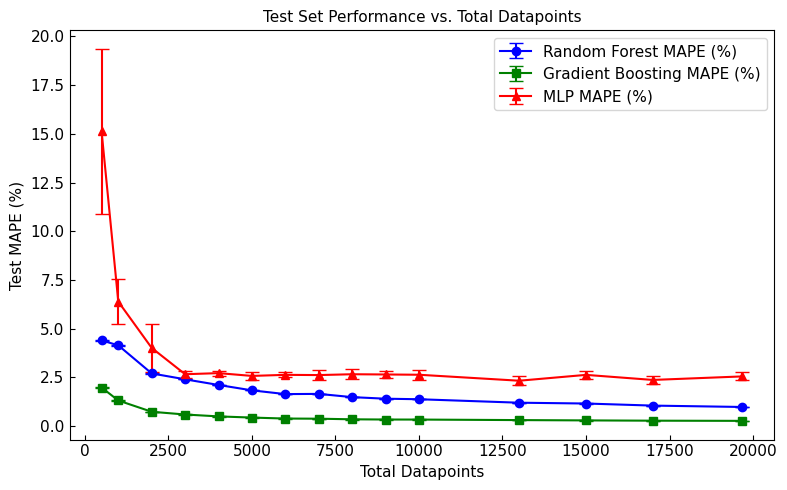

In [51]:
# Plot performance vs. total datapoints with error bars for all models
plt.figure(figsize=(8,5))
plt.errorbar(performance_df['total_datapoints'], performance_df['RF_MAPE_mean'], yerr=performance_df['RF_MAPE_CI'],
             marker='o', linestyle='-', label="Random Forest MAPE (%)", color='blue', capsize=5)
plt.errorbar(performance_df['total_datapoints'], performance_df['GB_MAPE_mean'], yerr=performance_df['GB_MAPE_CI'],
             marker='s', linestyle='-', label="Gradient Boosting MAPE (%)", color='green', capsize=5)
plt.errorbar(performance_df['total_datapoints'], performance_df['MLP_MAPE_mean'], yerr=performance_df['MLP_MAPE_CI'],
             marker='^', linestyle='-', label="MLP MAPE (%)", color='red', capsize=5)
plt.xlabel("Total Datapoints", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Test Set Performance vs. Total Datapoints", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tick_params(axis='both', direction='in', labelsize=11)
plt.legend(fontsize=11)
#plt.grid(True)
#plt.xscale('log')
plt.tight_layout()
plt.savefig("performance_vs_datapoints_with_errorbars.png", dpi=300)
plt.show()

## SHAP-based feature importance

Plotting for 5 random values

Explaining test sample index: 7936, True βₚ: 7.20


  0%|          | 0/1 [00:00<?, ?it/s]

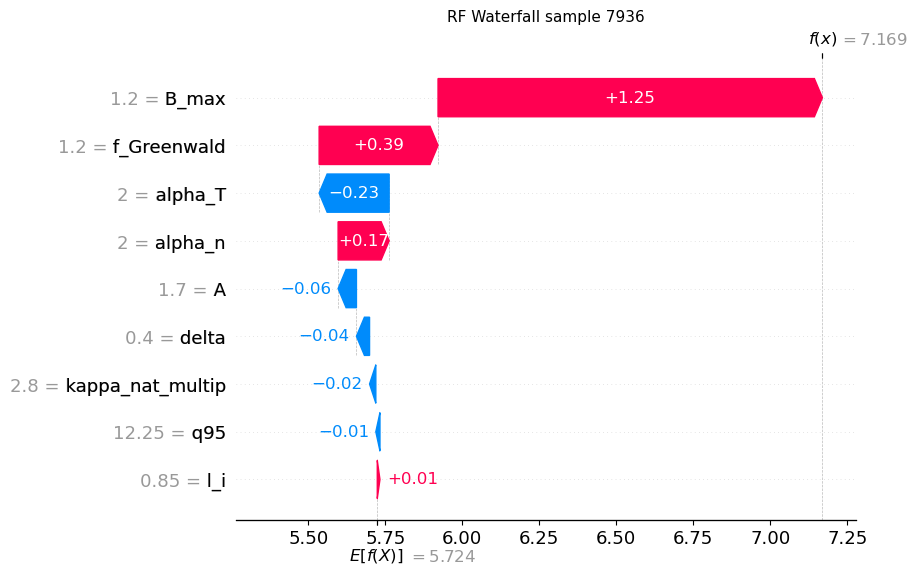

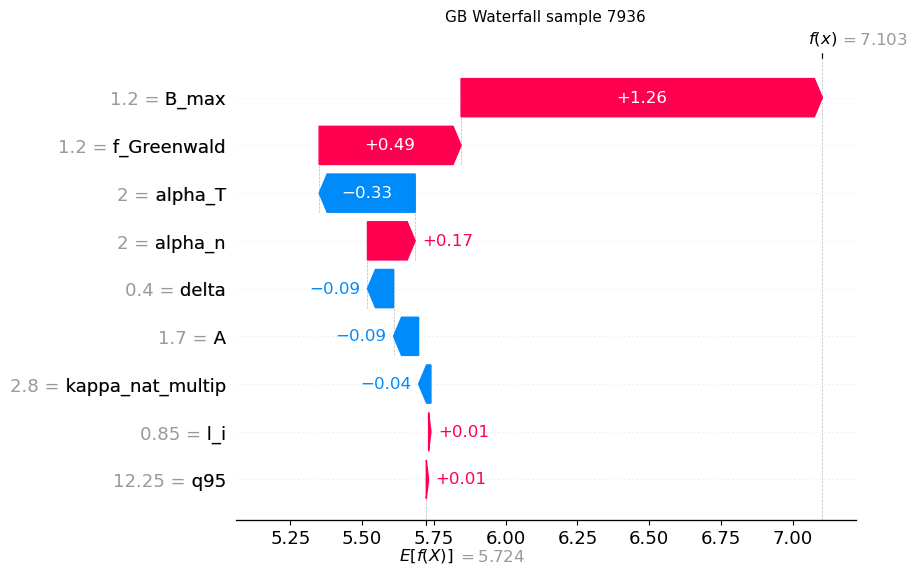

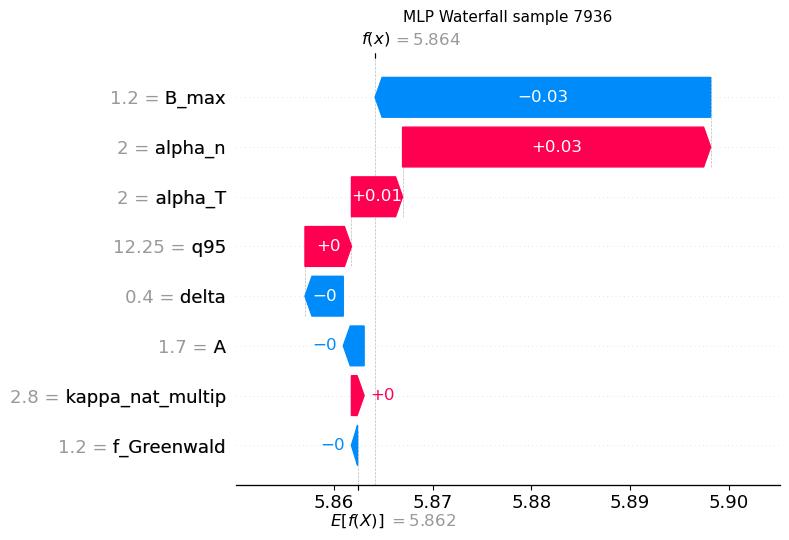

Explaining test sample index: 3488, True βₚ: 6.30


  0%|          | 0/1 [00:00<?, ?it/s]

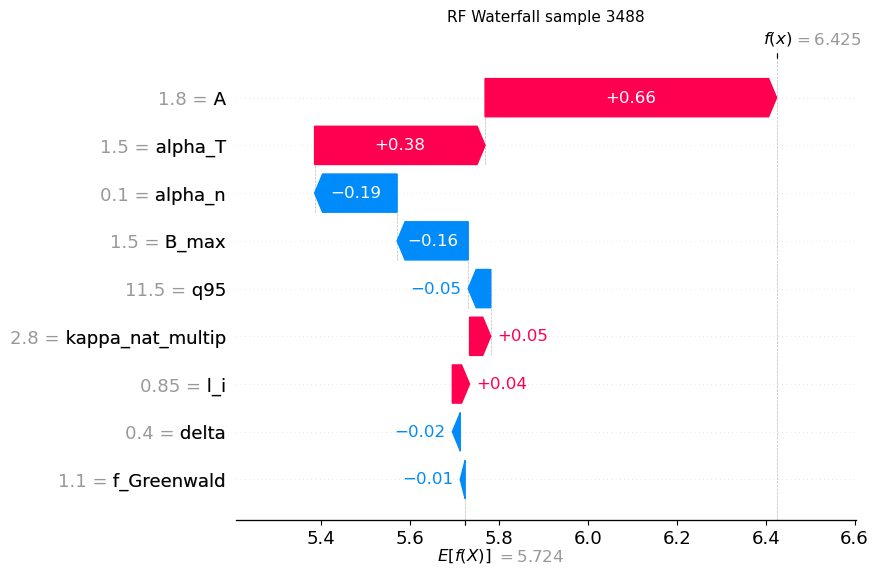

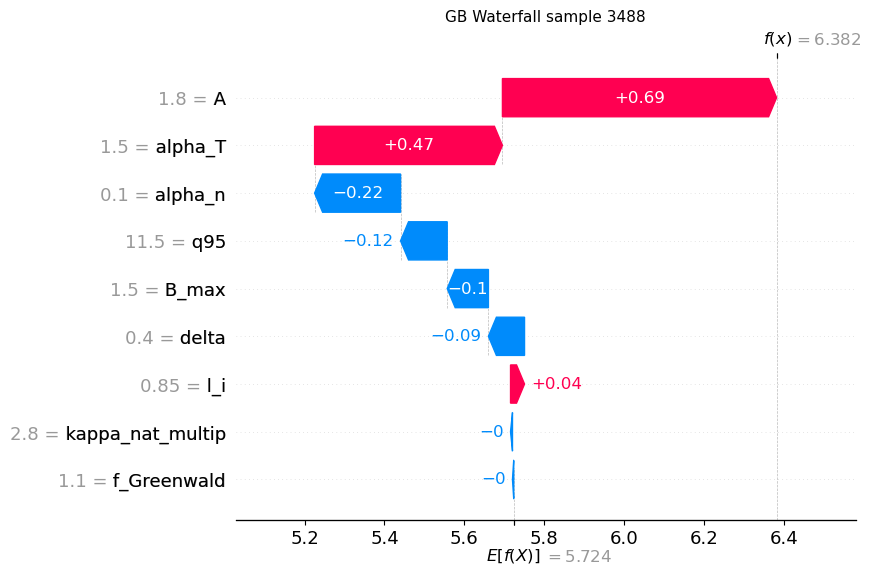

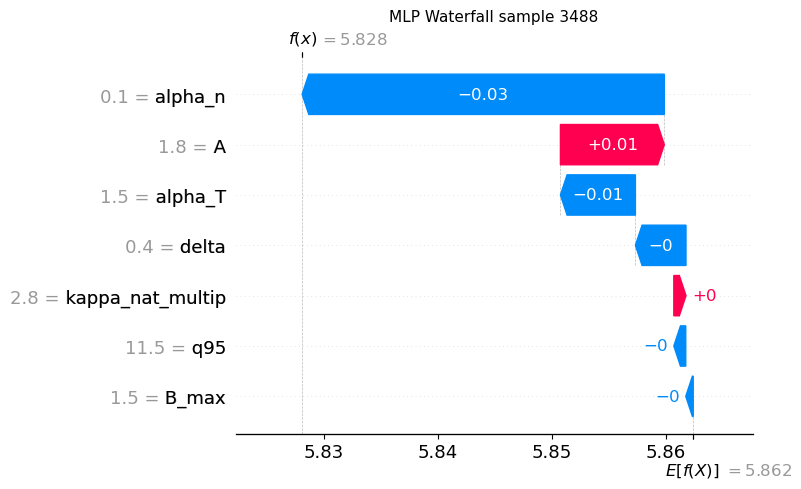

Explaining test sample index: 17877, True βₚ: 4.76


  0%|          | 0/1 [00:00<?, ?it/s]

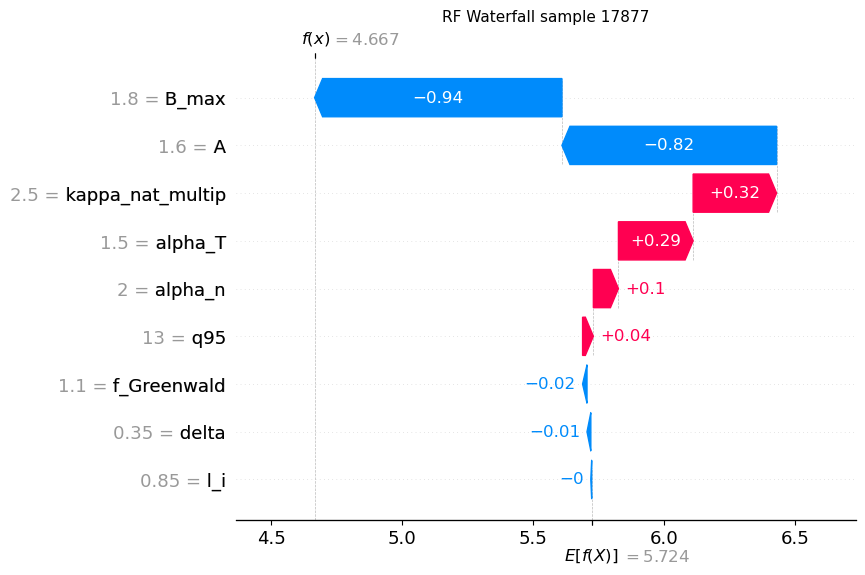

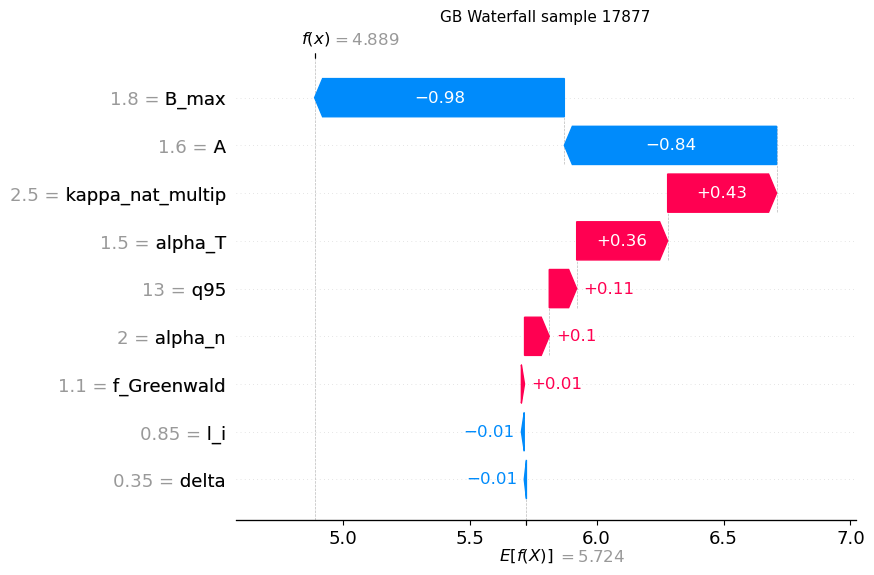

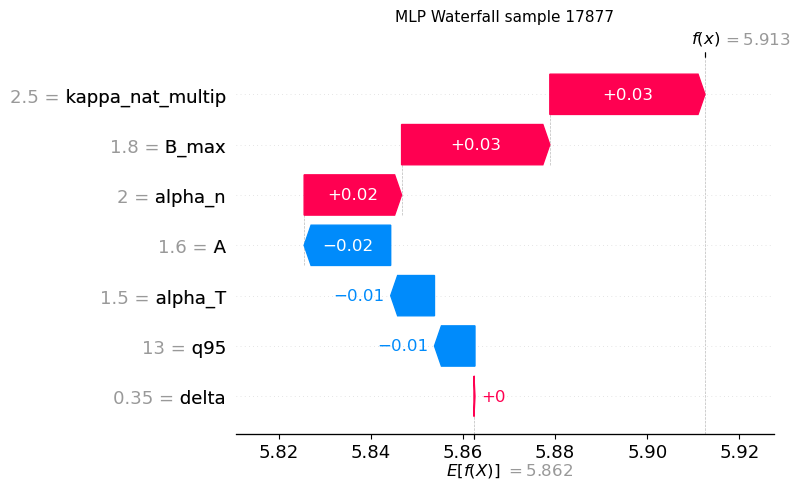

Explaining test sample index: 499, True βₚ: 6.61


  0%|          | 0/1 [00:00<?, ?it/s]

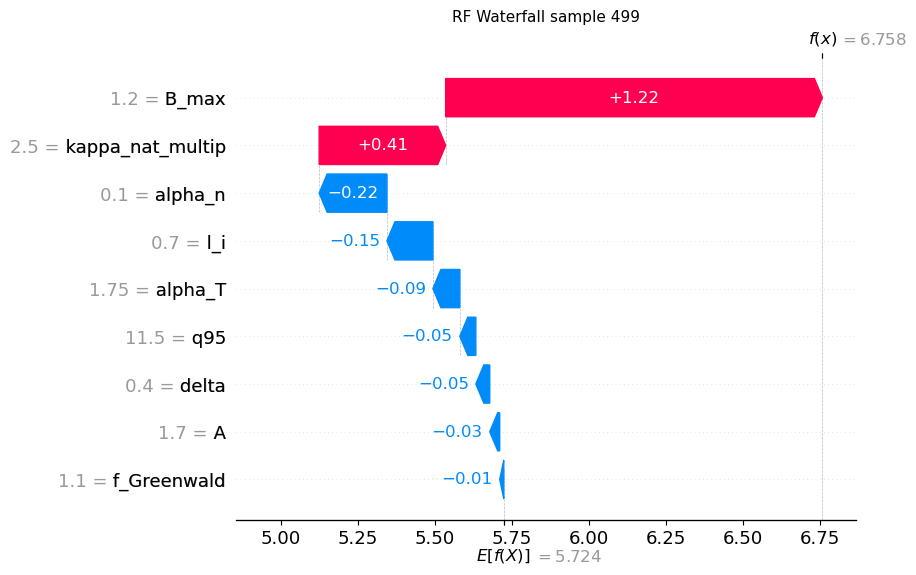

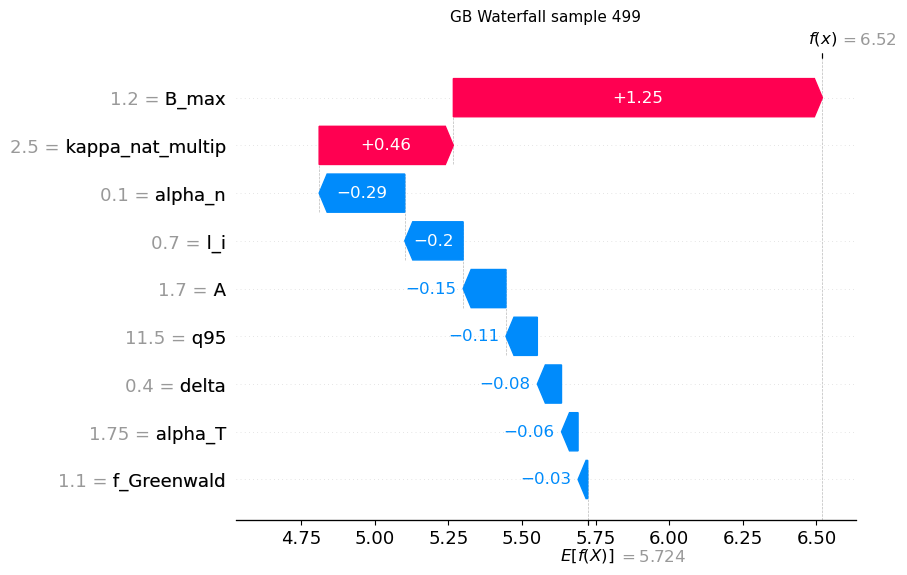

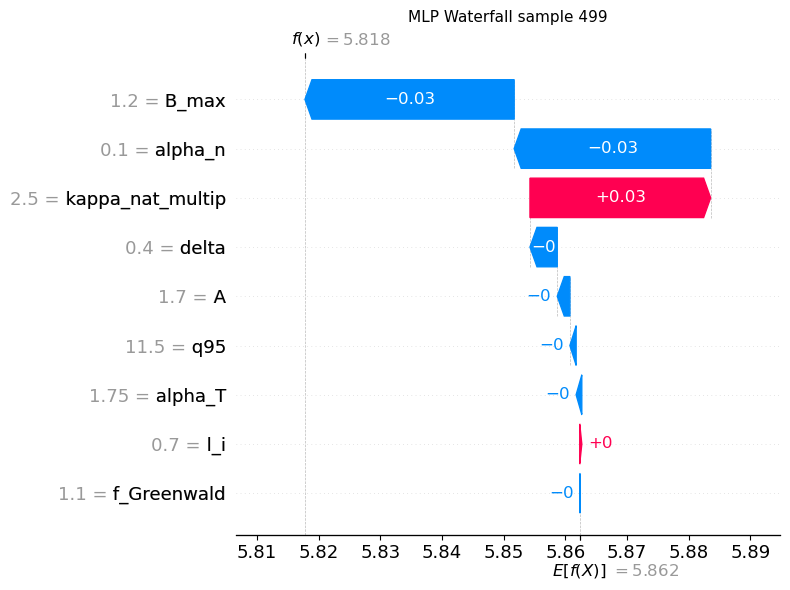

Explaining test sample index: 2724, True βₚ: 5.09


  0%|          | 0/1 [00:00<?, ?it/s]

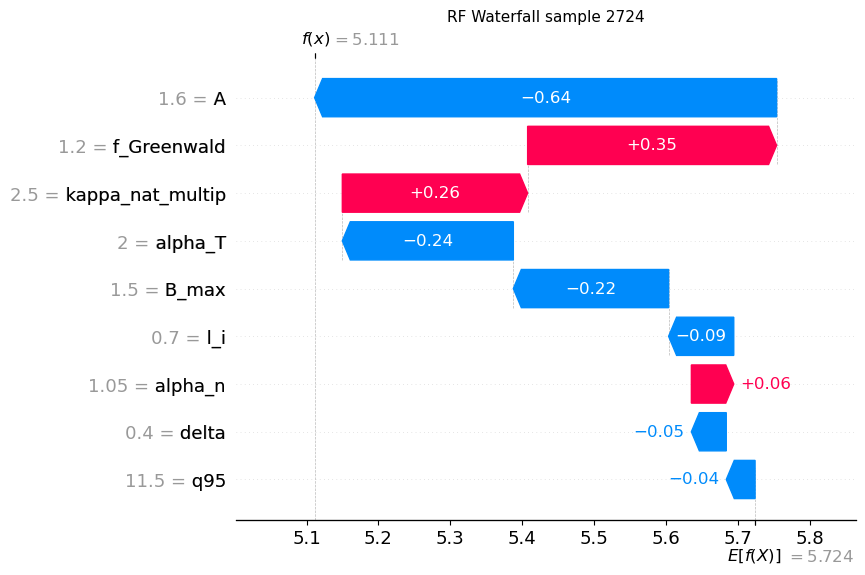

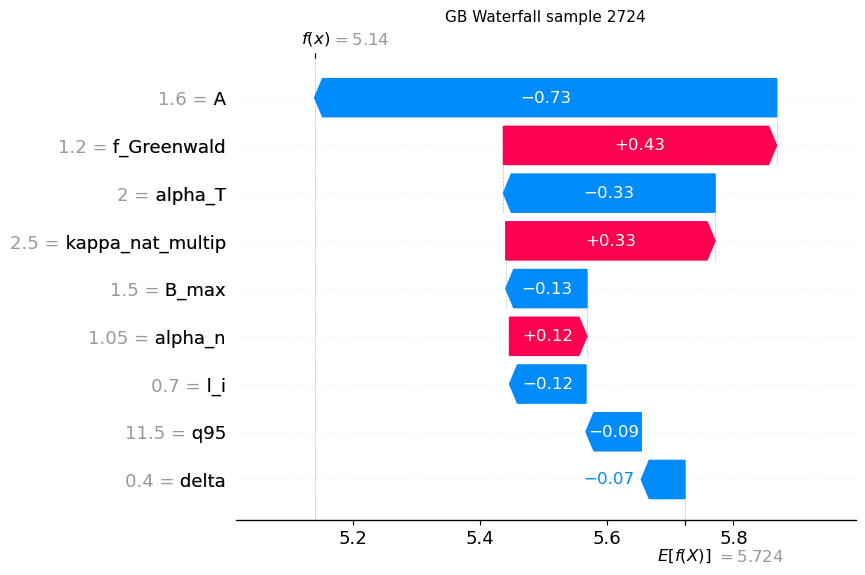

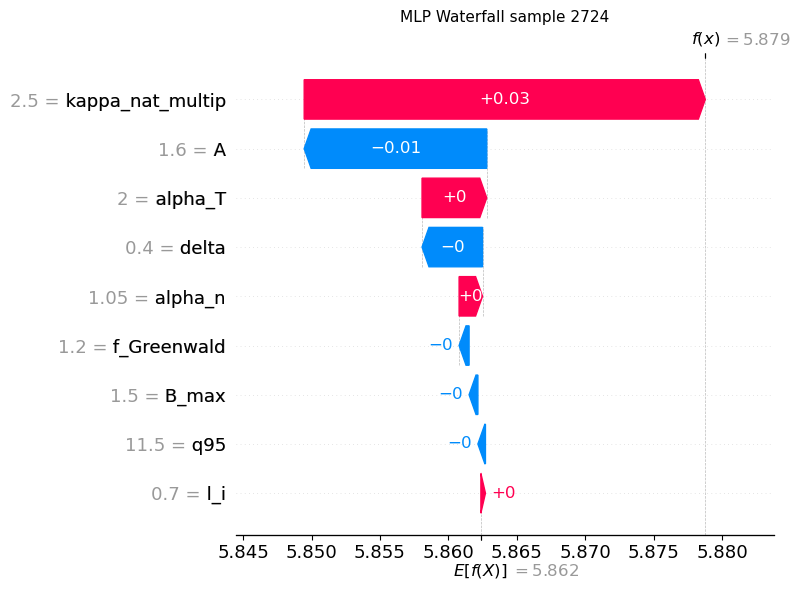

In [ ]:
# Set a threshold for negligible SHAP contributions. Features that do not contribute are not plotted
threshold = 1e-6

# 5 random test samples
num_samples = 5
np.random.seed(30)
sample_indices = np.random.choice(X_test.index, size=num_samples, replace=False)

for idx in sample_indices:
    x_sample = X_test.loc[[idx]] 
    true_beta = y_test.loc[idx]
    print(f"Explaining test sample index: {idx}, True βₚ: {true_beta:.2f}")
    
    # Random Forest Explanation
    rf_explainer = shap.TreeExplainer(rf_model)
    shap_values_rf = rf_explainer.shap_values(x_sample)
    rf_exp = shap.Explanation(
        values=shap_values_rf[0],
        base_values=rf_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )
    # Filter negligible contributions for RF
    nonzero_idx_rf = np.where(np.abs(rf_exp.values) > threshold)[0]
    if len(nonzero_idx_rf) > 0:
        filtered_rf_exp = shap.Explanation(
            values=rf_exp.values[nonzero_idx_rf],
            base_values=rf_exp.base_values,
            feature_names=np.array(rf_exp.feature_names)[nonzero_idx_rf],
            data=rf_exp.data[nonzero_idx_rf]
        )
    else:
        filtered_rf_exp = rf_exp

    # Gradient Boosting Explanation
    gb_explainer = shap.TreeExplainer(gb_model)
    shap_values_gb = gb_explainer.shap_values(x_sample)
    gb_exp = shap.Explanation(
        values=shap_values_gb[0],
        base_values=gb_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )
    # Filter negligible contributions for GB
    nonzero_idx_gb = np.where(np.abs(gb_exp.values) > threshold)[0]
    if len(nonzero_idx_gb) > 0:
        filtered_gb_exp = shap.Explanation(
            values=gb_exp.values[nonzero_idx_gb],
            base_values=gb_exp.base_values,
            feature_names=np.array(gb_exp.feature_names)[nonzero_idx_gb],
            data=gb_exp.data[nonzero_idx_gb]
        )
    else:
        filtered_gb_exp = gb_exp

    # MLP Explanation
    background = X_train.sample(n=100, random_state=42)
    mlp_explainer = shap.KernelExplainer(mlp_model.predict, background)
    shap_values_mlp = mlp_explainer.shap_values(x_sample)
    mlp_exp = shap.Explanation(
        values=shap_values_mlp[0],
        base_values=mlp_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )
    # Filter negligible contributions for MLP
    nonzero_idx_mlp = np.where(np.abs(mlp_exp.values) > threshold)[0]
    if len(nonzero_idx_mlp) > 0:
        filtered_mlp_exp = shap.Explanation(
            values=mlp_exp.values[nonzero_idx_mlp],
            base_values=mlp_exp.base_values,
            feature_names=np.array(mlp_exp.feature_names)[nonzero_idx_mlp],
            data=mlp_exp.data[nonzero_idx_mlp]
        )
    else:
        filtered_mlp_exp = mlp_exp

    # Plot RF, GB, and MLP Waterfall Plots 

    # RF
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_rf_exp, max_display=len(filtered_rf_exp.feature_names), show=False)
    plt.title(f"RF Waterfall sample {idx}", fontsize=11)
    plt.savefig(f"RF_sample_{idx}.png", dpi=300)
    
    # GB 
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_gb_exp, max_display=len(filtered_gb_exp.feature_names), show=False)
    plt.title(f"GB Waterfall sample {idx}", fontsize=11)
    plt.savefig(f"GB_sample_{idx}.png", dpi=300)

    # MLP
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_mlp_exp, max_display=len(filtered_mlp_exp.feature_names), show=False)
    plt.title(f"MLP Waterfall sample {idx}", fontsize=11)
    plt.tight_layout()
    plt.savefig(f"MLP_sample_{idx}.png", dpi=300)
    plt.show()


Plotting the absolute values

Explaining test sample index: 7936, True βₚ: 7.20


  0%|          | 0/1 [00:00<?, ?it/s]

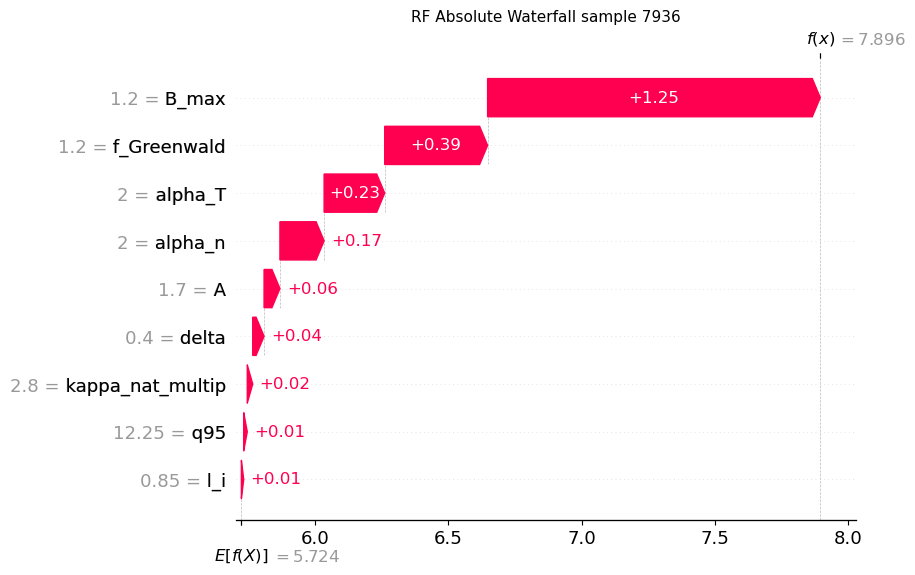

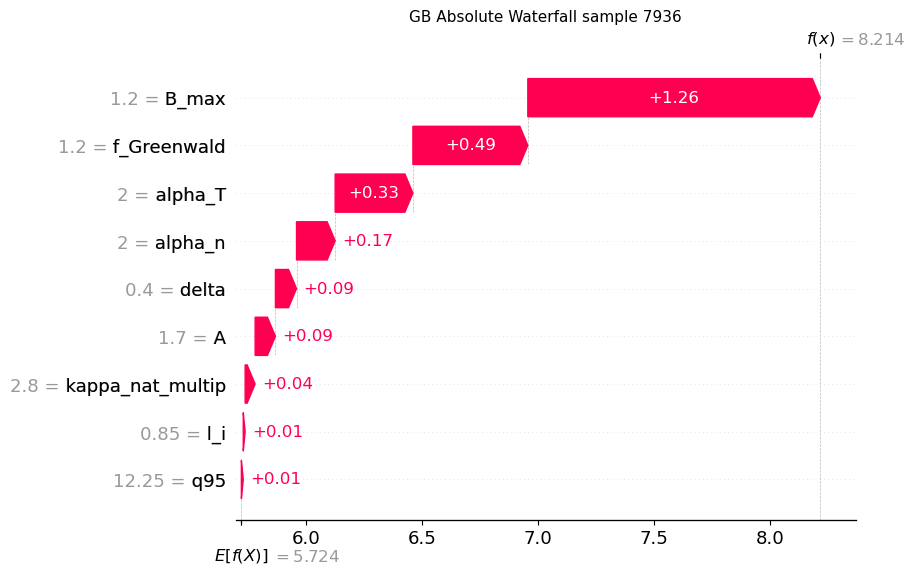

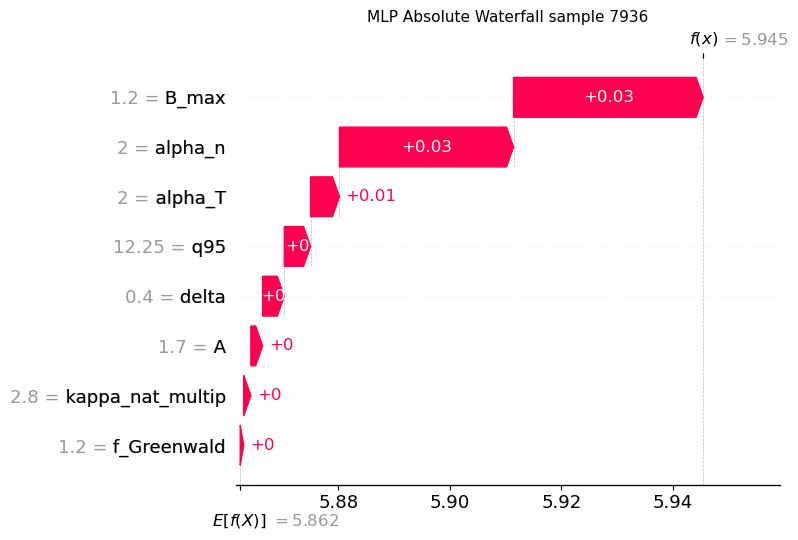

Explaining test sample index: 3488, True βₚ: 6.30


  0%|          | 0/1 [00:00<?, ?it/s]

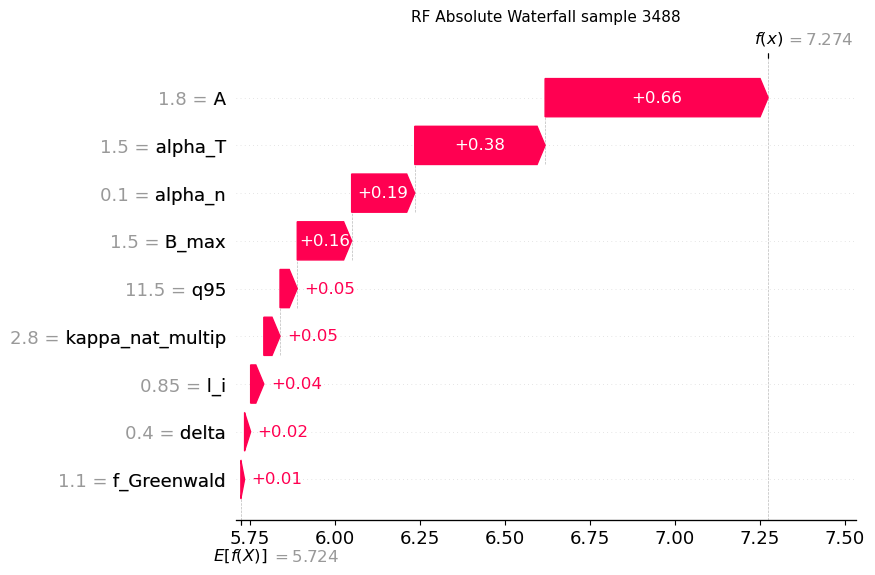

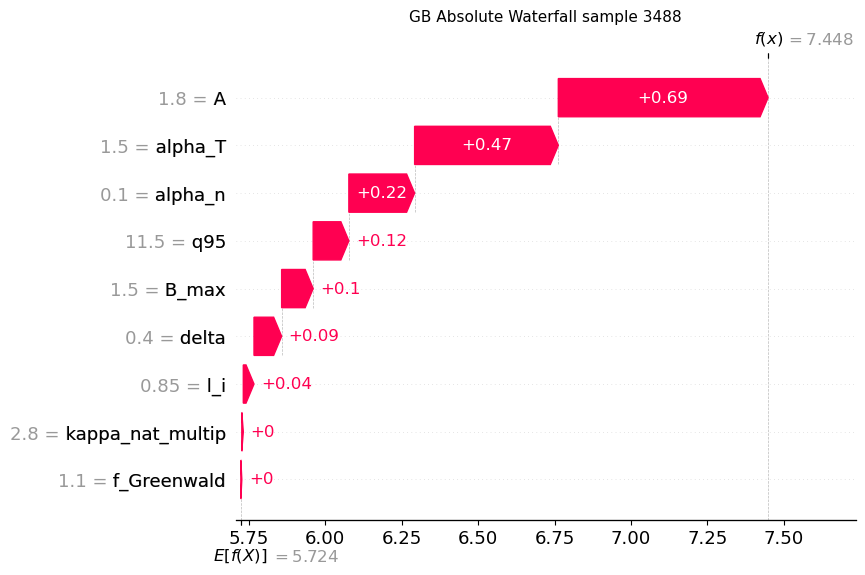

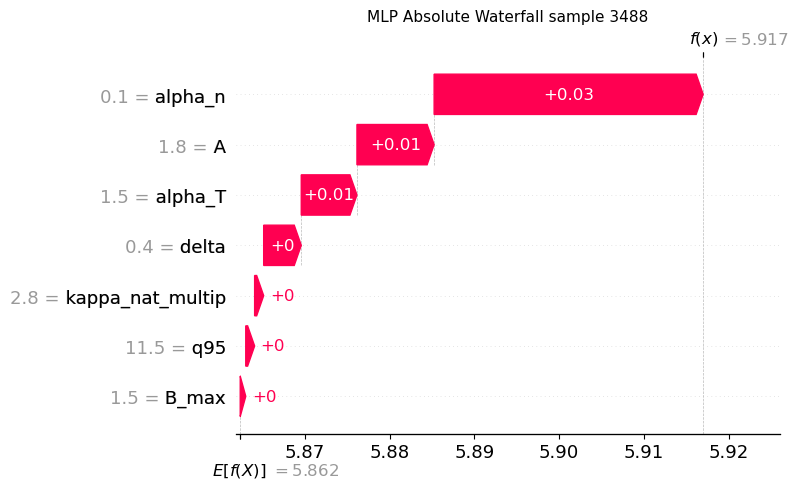

Explaining test sample index: 17877, True βₚ: 4.76


  0%|          | 0/1 [00:00<?, ?it/s]

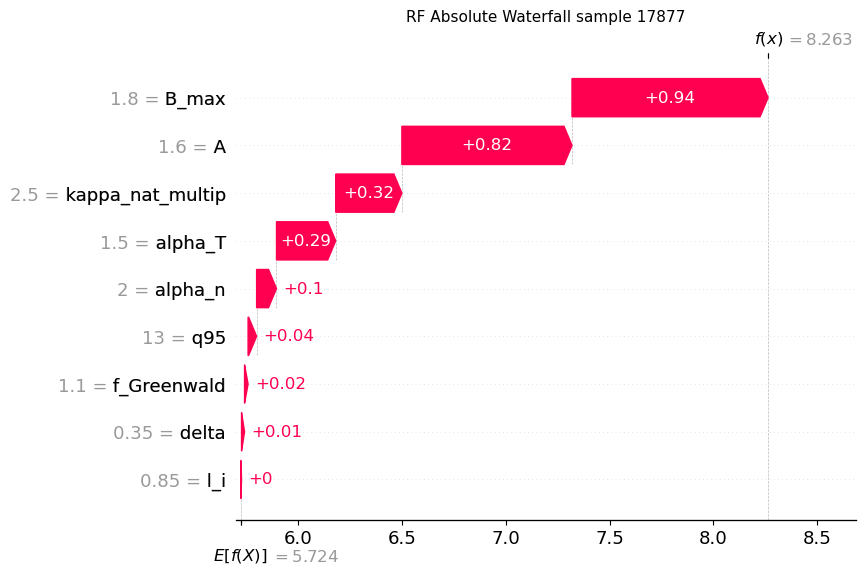

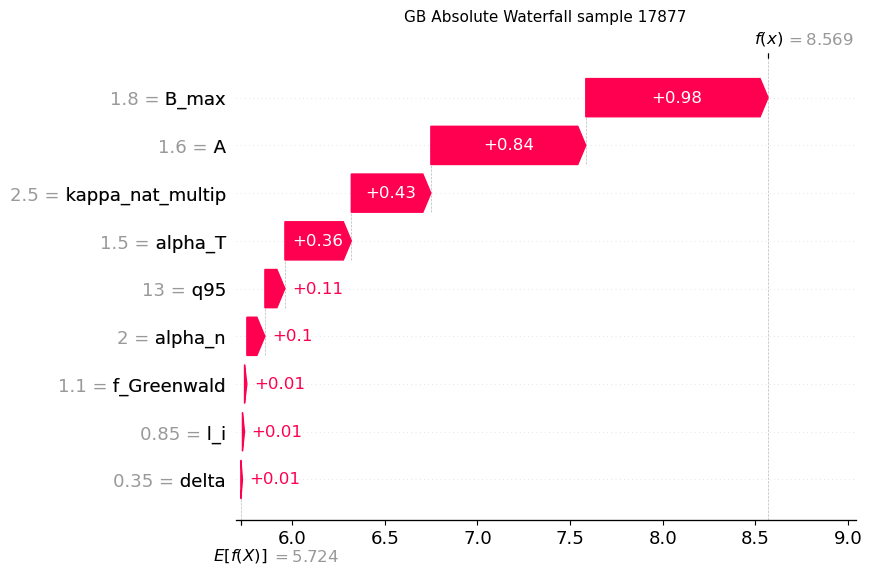

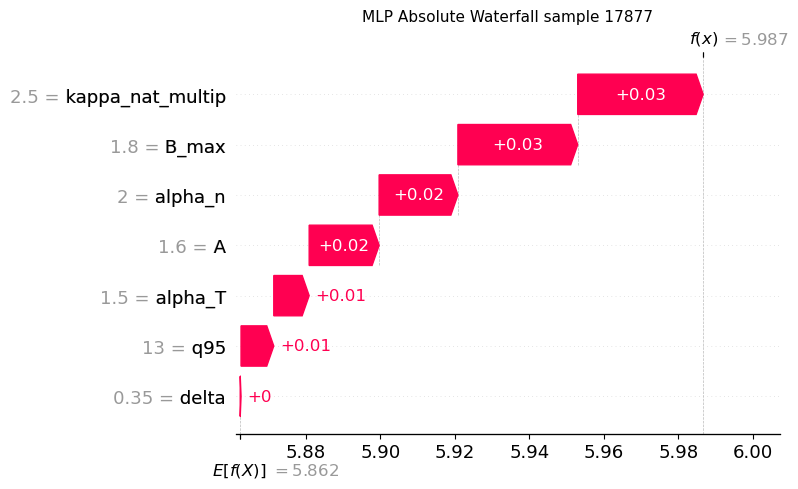

Explaining test sample index: 499, True βₚ: 6.61


  0%|          | 0/1 [00:00<?, ?it/s]

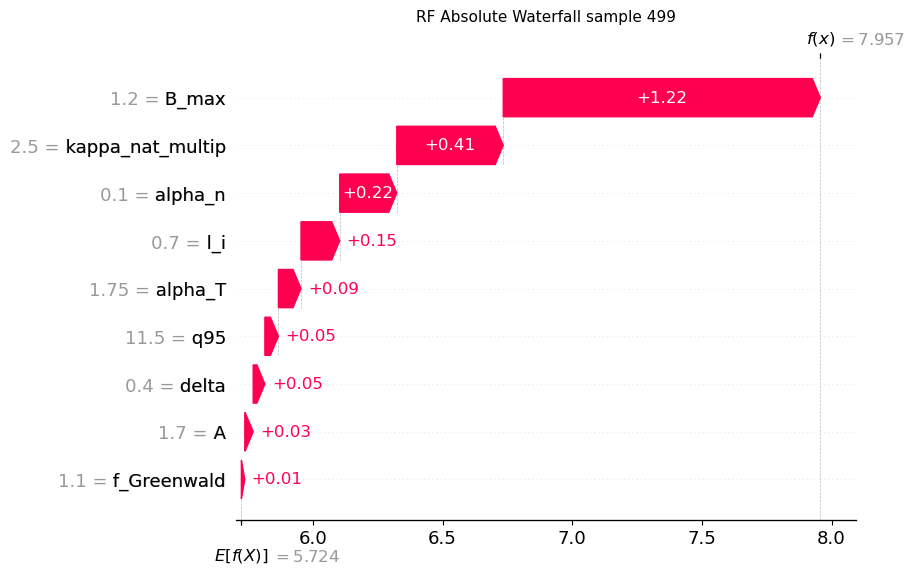

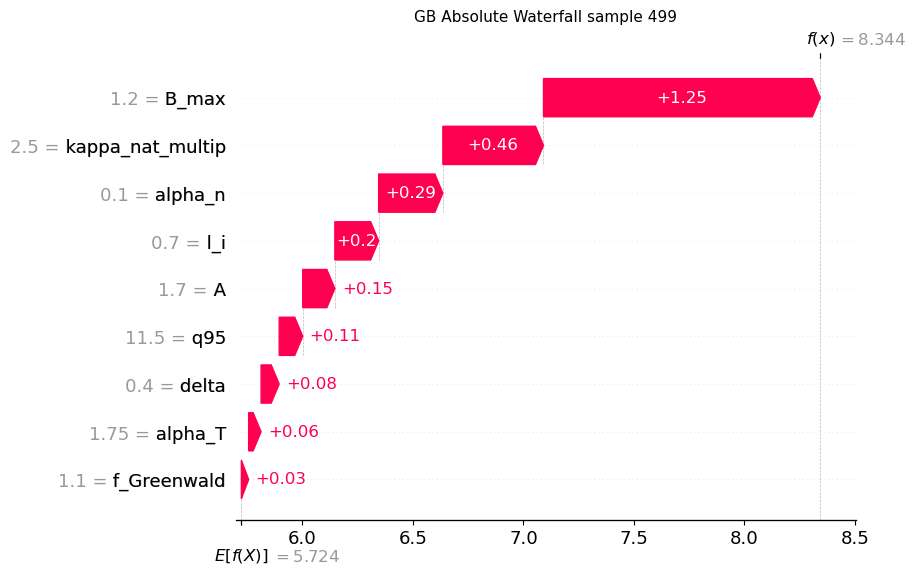

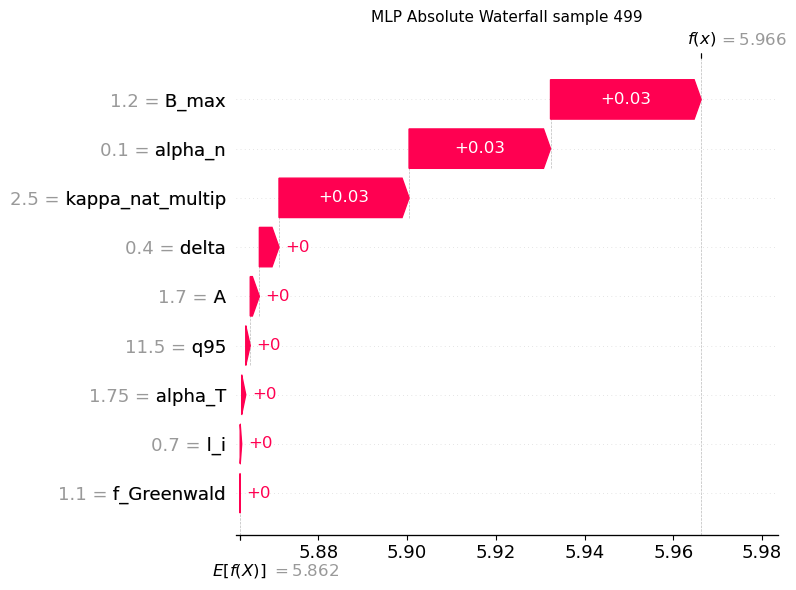

Explaining test sample index: 2724, True βₚ: 5.09


  0%|          | 0/1 [00:00<?, ?it/s]

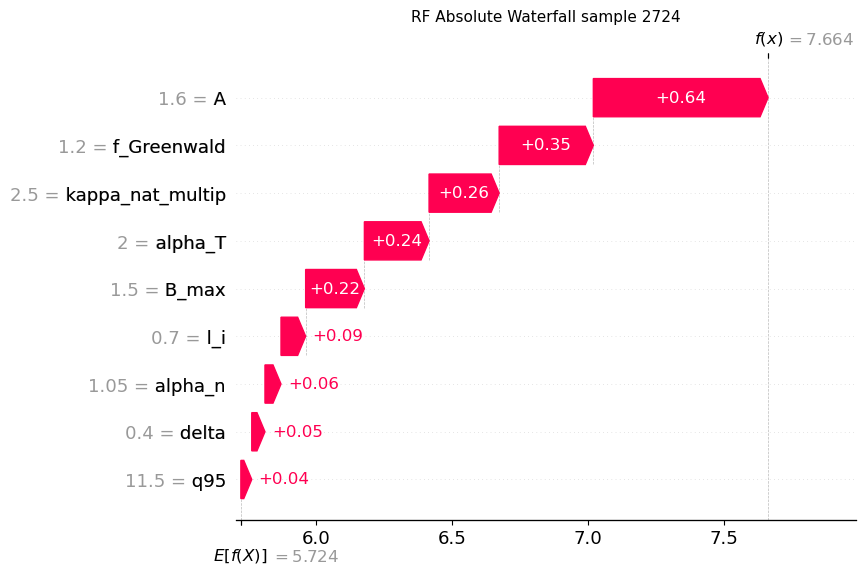

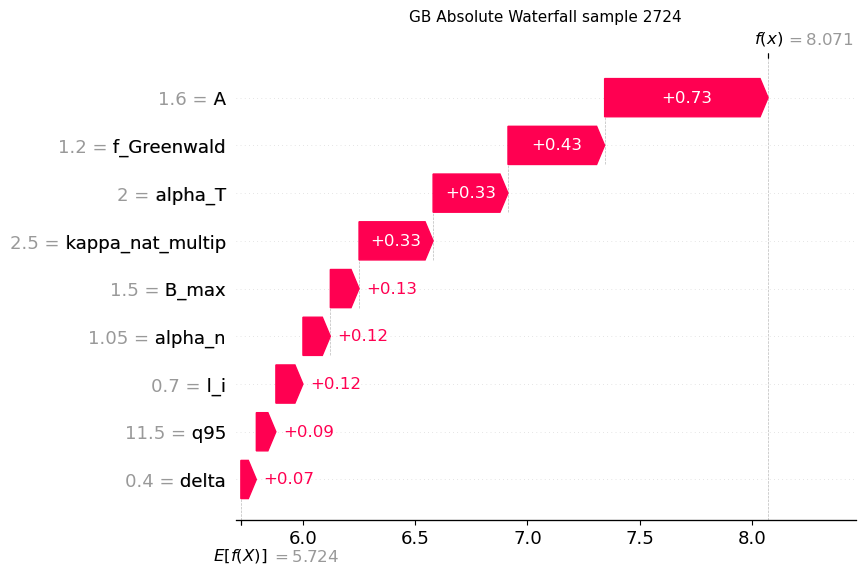

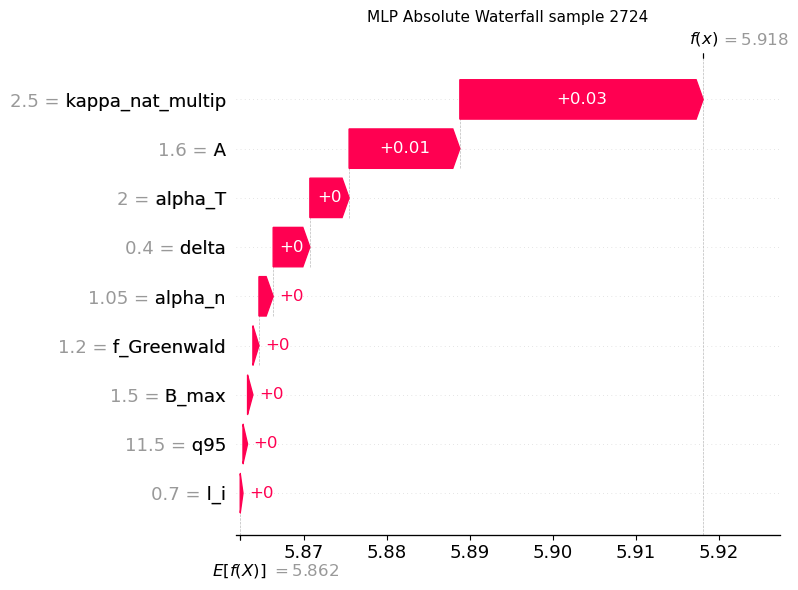

In [ ]:
# Absolute SHAP plots

for idx in sample_indices:
    x_sample = X_test.loc[[idx]]
    true_beta = y_test.loc[idx]
    print(f"Explaining test sample index: {idx}, True βₚ: {true_beta:.2f}")
    
    # RF
    rf_explainer = shap.TreeExplainer(rf_model)
    shap_values_rf = rf_explainer.shap_values(x_sample)

    rf_exp = shap.Explanation(
        values=np.abs(shap_values_rf[0]),
        base_values=rf_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )

    nonzero_idx_rf = np.where(rf_exp.values > threshold)[0]
    filtered_rf_exp = shap.Explanation(
        values=rf_exp.values[nonzero_idx_rf],
        base_values=rf_exp.base_values,
        feature_names=np.array(rf_exp.feature_names)[nonzero_idx_rf],
        data=rf_exp.data[nonzero_idx_rf]
    )
    
    # GB
    gb_explainer = shap.TreeExplainer(gb_model)
    shap_values_gb = gb_explainer.shap_values(x_sample)
    gb_exp = shap.Explanation(
        values=np.abs(shap_values_gb[0]),
        base_values=gb_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )
    nonzero_idx_gb = np.where(gb_exp.values > threshold)[0]
    filtered_gb_exp = shap.Explanation(
        values=gb_exp.values[nonzero_idx_gb],
        base_values=gb_exp.base_values,
        feature_names=np.array(gb_exp.feature_names)[nonzero_idx_gb],
        data=gb_exp.data[nonzero_idx_gb]
    )
    
    # MLP
    background = X_train.sample(n=100, random_state=42)
    mlp_explainer = shap.KernelExplainer(mlp_model.predict, background)
    shap_values_mlp = mlp_explainer.shap_values(x_sample)
    mlp_exp = shap.Explanation(
        values=np.abs(shap_values_mlp[0]),
        base_values=mlp_explainer.expected_value,
        feature_names=x_sample.columns,
        data=x_sample.iloc[0]
    )
    nonzero_idx_mlp = np.where(mlp_exp.values > threshold)[0]
    filtered_mlp_exp = shap.Explanation(
        values=mlp_exp.values[nonzero_idx_mlp],
        base_values=mlp_exp.base_values,
        feature_names=np.array(mlp_exp.feature_names)[nonzero_idx_mlp],
        data=mlp_exp.data[nonzero_idx_mlp]
    )
    
    # Plotting the absolute plots

    # RF
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_rf_exp, max_display=len(filtered_rf_exp.feature_names), show=False)
    plt.title(f"RF Absolute Waterfall sample {idx}", fontsize=11)
    plt.savefig(f"RF_absolute_sample_{idx}.png", dpi=300)
    
    # GB 
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_gb_exp, max_display=len(filtered_gb_exp.feature_names), show=False)
    plt.title(f"GB Absolute Waterfall sample {idx}", fontsize=11)
    plt.savefig(f"GB_absolute_sample_{idx}.png", dpi=300)

    # MLP
    plt.figure(figsize=(8, 6))
    shap.waterfall_plot(filtered_mlp_exp, max_display=len(filtered_mlp_exp.feature_names), show=False)
    plt.title(f"MLP Absolute Waterfall sample {idx}", fontsize=11)
    plt.tight_layout()
    plt.savefig(f"MLP_absolute_sample_{idx}.png", dpi=300)
    plt.show()


Aggregating across the whole dataset for RF and GB and producing global plots for the models

Identified variable features: ['q95', 'B_max', 'kappa_nat_multip', 'delta', 'l_i', 'alpha_n', 'alpha_T', 'f_Greenwald', 'A']


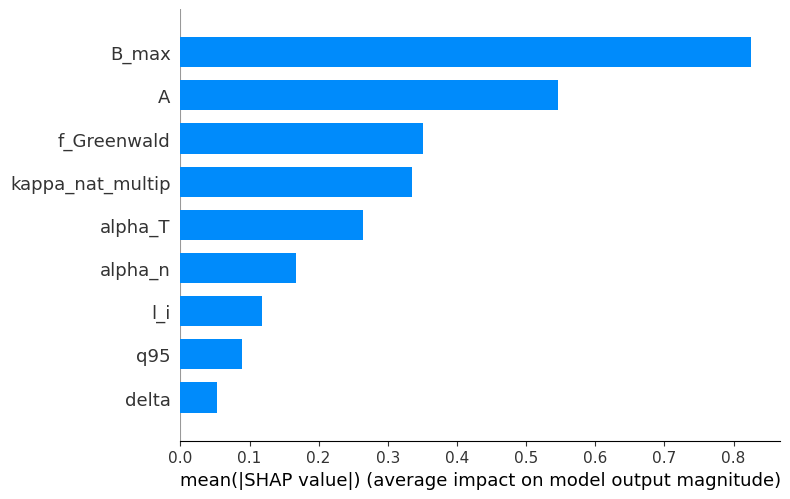

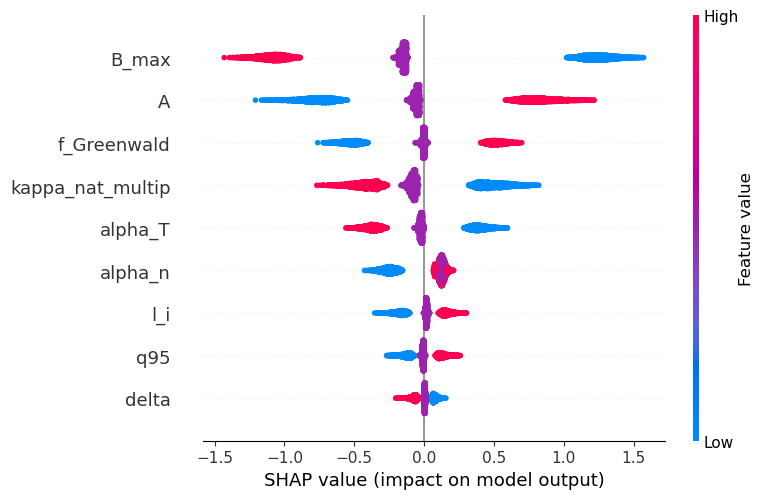

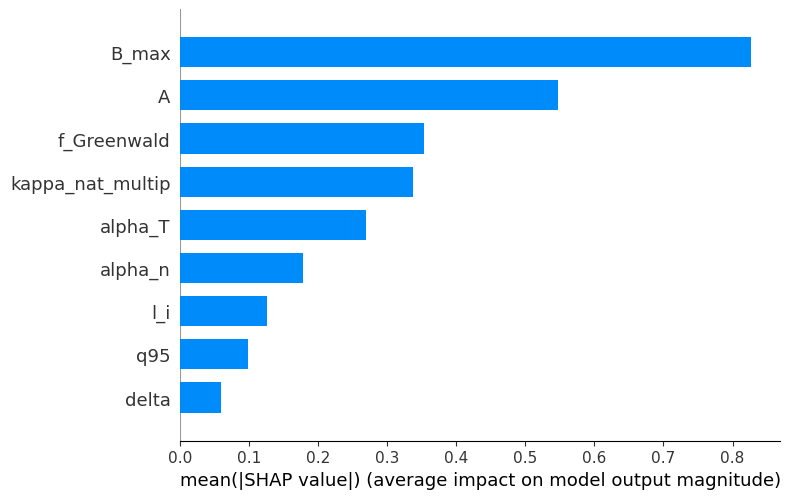

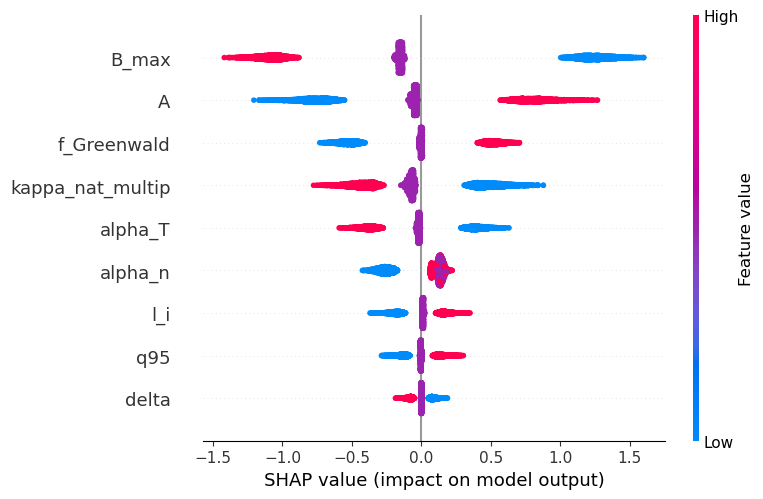

NameError: name 'mlp_model' is not defined

In [ ]:
# Determine variable features from X_test: whose std > threshold.
threshold_std = 1e-6
variable_features = [col for col in X_test.columns if np.std(X_test[col]) > threshold_std]
print("Identified variable features:", variable_features)

# Random Forest Aggregated Explanation
rf_explainer = shap.TreeExplainer(rf_model)
shap_values_rf = rf_explainer.shap_values(X_test)

# Get indices of variable features in X_test
variable_idx = [i for i, col in enumerate(X_test.columns) if col in variable_features]
rf_shap_values_var = shap_values_rf[:, variable_idx]
X_test_var = X_test[variable_features]

plt.figure(figsize=(12,6))
shap.summary_plot(rf_shap_values_var, X_test_var, plot_type="bar", show=False, 
                  title="RF Feature Importance (Bar, Variable Features Only)")
plt.tight_layout()
plt.savefig("rf_feature_importance_variable.png", dpi=300)
plt.show()

plt.figure(figsize=(12,6))
shap.summary_plot(rf_shap_values_var, X_test_var, show=False, 
                  title="RF Feature Importance (Beeswarm, Variable Features Only)")
plt.tight_layout()
plt.savefig("rf_feature_importance_beeswarm_variable.png", dpi=300)
plt.show()


# Gradient Boosting Aggregated Explanation
gb_explainer = shap.TreeExplainer(gb_model)
shap_values_gb = gb_explainer.shap_values(X_test)
variable_idx = [i for i, col in enumerate(X_test.columns) if col in variable_features]
gb_shap_values_var = shap_values_gb[:, variable_idx]
X_test_var = X_test[variable_features]

plt.figure(figsize=(12,6))
shap.summary_plot(gb_shap_values_var, X_test_var, plot_type="bar", show=False, 
                  title="GB Feature Importance (Bar, Variable Features Only)")
plt.tight_layout()
plt.savefig("gb_feature_importance_variable.png", dpi=300)
plt.show()

plt.figure(figsize=(12,6))
shap.summary_plot(gb_shap_values_var, X_test_var, show=False, 
                  title="GB Feature Importance (Beeswarm, Variable Features Only)")
plt.tight_layout()
plt.savefig("gb_feature_importance_beeswarm_variable.png", dpi=300)
plt.show()

Aggregating across the whole dataset for MLP

  0%|          | 0/200 [00:00<?, ?it/s]

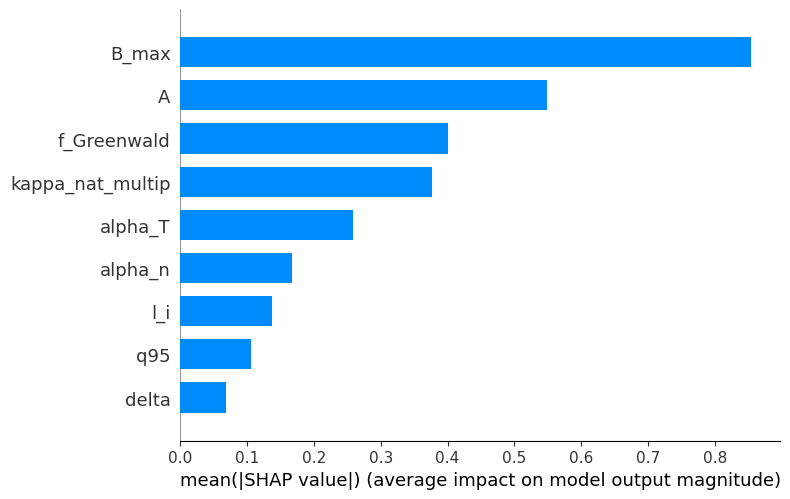

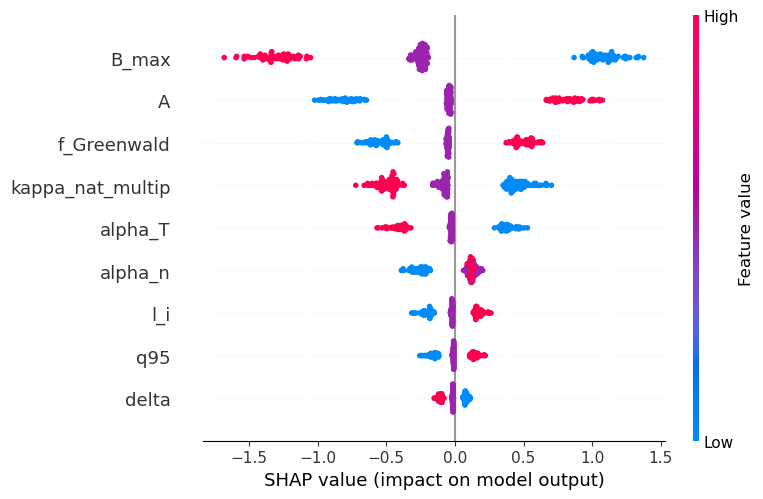

In [ ]:
# MLP Aggregated Explanation

# Use the full training set as background
background = X_train.sample(n=100, random_state=42)
mlp_explainer = shap.KernelExplainer(mlp_model.predict, background)

# Use a subset of X_test with all features for speed.
if len(X_test) >= 200:
    X_test_subset_full = X_test.sample(n=200, random_state=42)
    y_test_subset = y_test.loc[X_test_subset_full.index]
else:
    X_test_subset_full = X_test.copy()

# Compute SHAP values for the full feature set.
shap_values_mlp_full = mlp_explainer.shap_values(X_test_subset_full)

# Determine indices of variable features in the full test set.
variable_idx = [i for i, col in enumerate(X_test_subset_full.columns) if col in variable_features]

# Filter the SHAP values and corresponding data for only variable features.
mlp_shap_values_var = shap_values_mlp_full[:, variable_idx]
X_test_subset_var = X_test_subset_full[variable_features]

plt.figure(figsize=(12,6))
shap.summary_plot(mlp_shap_values_var, X_test_subset_var, plot_type="bar", show=False, 
                  title="MLP Feature Importance (Bar, Variable Features Only)")
plt.tight_layout()
plt.savefig("mlp_feature_importance_being_filtered.png", dpi=300)
plt.show()

plt.figure(figsize=(12,6))
shap.summary_plot(mlp_shap_values_var, X_test_subset_var, show=False, 
                  title="MLP Feature Importance (Beeswarm, Variable Features Only)")
plt.tight_layout()
plt.savefig("mlp_feature_importance_beeswarm_filtered.png", dpi=300)
plt.show()

Calculating the MAPE values

In [ ]:
# Random Forest
rf_pred_shap = rf_explainer.expected_value + np.sum(shap_values_rf, axis=1)
rf_mape_shap = mean_absolute_percentage_error(y_test, rf_pred_shap) * 100
print(f"Random Forest MAPE using SHAP predictions: {rf_mape_shap:.6f}%")

# Gradient Boosting
gb_pred_shap = gb_explainer.expected_value + np.sum(shap_values_gb, axis=1)
gb_mape_shap = mean_absolute_percentage_error(y_test, gb_pred_shap) * 100
print(f"Gradient Boosting MAPE using SHAP predictions: {gb_mape_shap:.6f}%")

# MLP
mlp_pred_shap = mlp_explainer.expected_value + np.sum(shap_values_mlp_full, axis=1)
mlp_mape_shap = mean_absolute_percentage_error(y_test_subset, mlp_pred_shap) * 100
print(f"MLP MAPE using SHAP predictions: {mlp_mape_shap:.6f}%")

Random Forest MAPE using SHAP predictions: 0.982346%
Gradient Boosting MAPE using SHAP predictions: 0.278496%
MLP MAPE using SHAP predictions: 1.617406%


## Active Learning

In [ ]:
# generating the data again

all_params = {
    'q95': (11.5, 13.0),            # variable safety factor 
    'B_max': (1.2, 1.8),            # variable Maximum magnetic field on inboard TF coil 
    'kappa_nat_multip': (2.5, 3.1), # variable natural plasma elongation
    'delta': (0.3,0.4),             # variable triangularity
    'l_i': (0.7,1),                 # variable internal inductance
    'alpha_n': (0.1,2.0),           # variable density profile peaking factor
    'alpha_T': (1.5,2.0),           # variable Temperature Peaking Factor
    'f_Greenwald': (1.0,1.2),       # variable  Greenwald fraction
    'f_core_rad': 0.35,             # fixed core Radiation Fraction
    'Z_i': 13.0,                    # fixed  Ion Charge Number 
    'Z_eff': 1.8,                   # fixed  Effective Plasma Charge State
    'EMF': 1.3,                     # fixed neutron Energy Multiplication Factor
    'gamma_CD': 0.18,               # fixed  current drive efficiency factor
    'eta_gen': 0.36,                # fixed.  Power Conversion Efficiency
    'eta_CD': 0.4,                  # fixed Current Drive Efficiency
    'f_BOP': 0.25,                  # fixed  Balance of Plant Efficiency Factor. fraction of generated electricity required for the BoP Balance of Plant (BoP)  Here BoP is taken to mean all the recycled power required for reactor operation
    'H': 1.0,                       # fixed Energy Confinement Enhancement Factor
    'A': (1.6,1.8),                 # variable from paper
    't_shield': 0.0114,             # fixed shield thickness
    'R_cc': 0.3,                    # fixed Radius of leg of inboard TF coil vault
    'Q': 20                         # fixed reactor Q value. Fusion Gain Factor
}

def sample_param(value, n_points=3):
    """
    Return sample values for a parameter using np.linspace.
    If value is a tuple, use its first two elements as the start and end.
    Otherwise, return [value].
    """
    if isinstance(value, tuple):
        start, end = value[0], value[1]
        return np.linspace(start, end, n_points)
    else:
        return [value]

def generate_dataset(all_params, n_points_fixed=3):
    """
    Generate a reproducible dataset by sampling every key with a tuple value using np.linspace.
    This produces 3^(# of keys with tuple values) datapoints.
    Then, for each complete set of inputs, calculate reactor outputs using calculate_reactor_parameters.
    The final DataFrame contains the input features (all values in all_params) and target value beta_P.
    """
    # Building a dictionary mapping each key to its sample list
    samples = {key: sample_param(val, n_points_fixed) for key, val in all_params.items()}
    
    # All keys provided as tuples are variable
    variable_keys = [k for k, v in samples.items() if len(v) > 1]
    constant_keys = [k for k, v in samples.items() if len(v) == 1]
    
    # Creating a grid for variable keys
    grid_list = list(product(*(samples[k] for k in variable_keys)))
    
    data = []
    for vals in grid_list:
        sample = {}
        # Assign variable parameters
        for key, val in zip(variable_keys, vals):
            sample[key] = val
        # Assign constant parameters
        for key in constant_keys:
            sample[key] = samples[key][0]
            
        # Calculate reactor outputs
        try:
            calc_results = calculate_reactor_parameters(sample['R_cc'], sample['B_max'], sample['Q'], sample)
        except Exception as e:
            calc_results = {}
            print(f"Error calculating reactor parameters for sample {sample}: {e}")
        sample.update(calc_results)
        # Ensure beta_P is present
        if 'beta_P' not in sample:
            sample['beta_P'] = np.nan
        data.append(sample)
    
    df = pd.DataFrame(data)
    # Use all keys in all_params as input features.
    feature_columns = list(all_params.keys())
    df = df[feature_columns + ['beta_P']]
    return df

# Generate the dataset.
AL_data = generate_dataset(all_params, n_points_fixed=3)
print("Dataset shape:", AL_data.shape)  # Should be 3^9 = 19,683 rows
display(AL_data)

In [ ]:
X_full = optimized_data.drop(columns=['beta_P'])
y_full = optimized_data['beta_P']
train_pool, X_test, y_train_pool, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Start with an initial labelled set of 1000 datapoints
initial_train_size = min(1000, len(train_pool))
initial_train_idx = np.random.choice(train_pool.index, size=initial_train_size, replace=False)
X_train_initial = train_pool.loc[initial_train_idx]
y_train_initial = y_train_pool.loc[initial_train_idx]

# Remove initial training samples from pool
unlabeled_pool = train_pool.drop(initial_train_idx)
y_unlabeled_pool = y_train_pool.drop(initial_train_idx)

# Uncertainty Function for Random Forest
def rf_uncertainty(model, X):
    # Collect predictions from each tree and return the standard deviation across trees for each sample
    predictions = np.array([tree.predict(X) for tree in model.estimators_])
    return np.std(predictions, axis=0)

# Active Learning Loop Parameters
num_iterations = 10     # Number of active learning iterations
pool_sample_size = 1000 # Each iteration, sample 1000 candidates from the pool
select_size = 100       # Select top 100 most uncertain datapoints each iteration

# storing performance metrics
training_sizes = []
test_MAPE = []

# initial training set
X_train = X_train_initial.copy()
y_train = y_train_initial.copy()

for it in range(num_iterations):
    # Training a Random Forest on the current training set, optimal hyperparameters obtained before
    rf_model = RandomForestRegressor(n_estimators=1000, max_depth=20, max_features=9, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluating on the fixed test set
    y_pred_test = rf_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    
    training_sizes.append(len(X_train))
    test_MAPE.append(mape)
    print(f"Iteration {it+1}: Training set size: {len(X_train)}, Test MAPE: {mape:.2f}%")
    
    if unlabeled_pool.shape[0] == 0:
        break
    
    # From the unlabeled pool, randomly sample candidate pool
    if unlabeled_pool.shape[0] < pool_sample_size:
        candidate_idx = unlabeled_pool.index
    else:
        candidate_idx = np.random.choice(unlabeled_pool.index, size=pool_sample_size, replace=False)
    X_candidates = unlabeled_pool.loc[candidate_idx]
    
    # Compute uncertainties for the candidate pool
    uncertainties = rf_uncertainty(rf_model, X_candidates)
    
    # Select indices of the top 'select_size' candidates with highest uncertainty
    uncertain_indices = X_candidates.index[np.argsort(-uncertainties)[:select_size]]
    
    # "Label" these datapoints by getting their true beta_P values
    X_new = unlabeled_pool.loc[uncertain_indices]
    y_new = y_unlabeled_pool.loc[uncertain_indices]
    
    # Add new datapoints to the training set
    X_train = pd.concat([X_train, X_new])
    y_train = pd.concat([y_train, y_new])
    
    # Remove these datapoints from the unlabeled pool
    unlabeled_pool = unlabeled_pool.drop(uncertain_indices)
    y_unlabeled_pool = y_unlabeled_pool.drop(uncertain_indices)


Iteration 1: Training set size: 1000, Test MAPE: 3.20%
Iteration 2: Training set size: 1100, Test MAPE: 3.19%
Iteration 3: Training set size: 1200, Test MAPE: 3.09%
Iteration 4: Training set size: 1300, Test MAPE: 3.09%
Iteration 5: Training set size: 1400, Test MAPE: 3.03%
Iteration 6: Training set size: 1500, Test MAPE: 2.99%
Iteration 7: Training set size: 1600, Test MAPE: 2.97%
Iteration 8: Training set size: 1700, Test MAPE: 2.89%
Iteration 9: Training set size: 1800, Test MAPE: 2.87%
Iteration 10: Training set size: 1900, Test MAPE: 2.82%


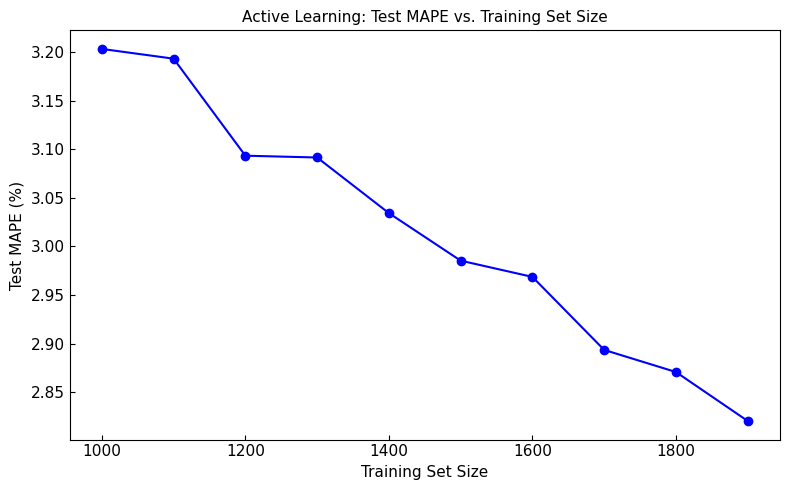

In [ ]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(training_sizes, test_MAPE, marker='o', linestyle='-', color='blue')
plt.xlabel("Training Set Size", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Active Learning: Test MAPE vs. Training Set Size", fontsize=11)
plt.tick_params(axis='both', which='both', direction='in', labelsize=11)
plt.tight_layout()
plt.savefig("active_learning_performance.png", dpi=300)
plt.show()

This works as expected, now lets create functions to try other strategies to compare. Trying random sampling.

In [ ]:
X_full = optimized_data.drop(columns=['beta_P'])
y_full = optimized_data['beta_P']
X_pool, X_test, y_pool, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [ ]:
# Random sampling
def run_active_learning(X_pool, y_pool, X_test, y_test, initial_train_size=1000, candidate_sample_size=1000, select_size=100, method='active'):
    """
    Runs one active learning experiment using either uncertainty sampling ('active')
    or random selection ('naive').
    
    Parameters:
      X_pool, y_pool: Candidate pool of unlabeled data.
      X_test, y_test: Fixed test set.
      initial_train_size: initial labelled set size.
      candidate_sample_size: number of datapoints sampled from pool each iteration.
      select_size: number of datapoints selected from candidate sample per iteration.
      method: 'active' uses uncertainty sampling (based on RF tree std), 'naive' selects randomly.
    
    Returns:
      training_sizes: list of training set sizes at each iteration.
      test_errors: list of test set MAPE values at each iteration.
    """
    X_pool_remaining = X_pool.copy()
    y_pool_remaining = y_pool.copy()
    
    # Select initial training set randomly
    initial_idx = np.random.choice(X_pool_remaining.index, size=initial_train_size, replace=False)
    X_train = X_pool_remaining.loc[initial_idx].copy()
    y_train = y_pool_remaining.loc[initial_idx].copy()
    # Remove initial training points from pool
    X_pool_remaining = X_pool_remaining.drop(initial_idx)
    y_pool_remaining = y_pool_remaining.drop(initial_idx)
    
    training_sizes = [len(X_train)]
    test_errors = []
    
    # Train a Random Forest on initial training set
    model = RandomForestRegressor(n_estimators=1000, max_depth=20, max_features=9, random_state=42)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    test_errors.append(mape)
    
    # Active learning loop
    while len(X_pool_remaining) >= select_size:
        # From the remaining pool, sample candidate_sample_size candidates
        if len(X_pool_remaining) < candidate_sample_size:
            candidate_idx = X_pool_remaining.index
        else:
            candidate_idx = np.random.choice(X_pool_remaining.index, size=candidate_sample_size, replace=False)
        X_candidates = X_pool_remaining.loc[candidate_idx]
        
        if method == 'active':
            # Use RF uncertainty: standard deviation across tree predictions
            candidate_preds = np.array([tree.predict(X_candidates) for tree in model.estimators_])
            uncertainties = np.std(candidate_preds, axis=0)
            # Select indices with highest uncertainty
            selected_indices = X_candidates.index[np.argsort(-uncertainties)[:select_size]]
        else:  # 'naive'
            selected_indices = np.random.choice(X_candidates.index, size=select_size, replace=False)
        
        # "Label" these points (get true y values)
        X_new = X_pool_remaining.loc[selected_indices]
        y_new = y_pool_remaining.loc[selected_indices]
        
        # Add new points to training set
        X_train = pd.concat([X_train, X_new])
        y_train = pd.concat([y_train, y_new])
        
        # Remove selected points from the pool
        X_pool_remaining = X_pool_remaining.drop(selected_indices)
        y_pool_remaining = y_pool_remaining.drop(selected_indices)
        
        training_sizes.append(len(X_train))
        # Retrain model and evaluate
        model = RandomForestRegressor(n_estimators=1000, max_depth=20, max_features=9, random_state=42)
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        test_errors.append(mape)
    
    return training_sizes, test_errors


# Run Active Learning Experiments (10 runs each for active and naive)
num_runs = 10
active_results = []
naive_results = []

for run in range(num_runs):
    # Reset candidate pool from full pool.
    X_pool_run = X_pool.copy()
    y_pool_run = y_pool.copy()
    
    ts_active, te_active = run_active_learning(X_pool_run, y_pool_run, X_test, y_test,
                                                initial_train_size=1000,
                                                candidate_sample_size=1000,
                                                select_size=100,
                                                method='active')
    active_results.append((ts_active, te_active))
    
    # For naive selection.
    X_pool_run = X_pool.copy()
    y_pool_run = y_pool.copy()
    ts_naive, te_naive = run_active_learning(X_pool_run, y_pool_run, X_test, y_test,
                                              initial_train_size=1000,
                                              candidate_sample_size=1000,
                                              select_size=100,
                                              method='naive')
    naive_results.append((ts_naive, te_naive))
    print(f"Run {run+1} complete.")

# Assuming all runs have same number of iterations
active_training_sizes = np.array([res[0] for res in active_results])
active_test_errors = np.array([res[1] for res in active_results])
naive_training_sizes = np.array([res[0] for res in naive_results])
naive_test_errors = np.array([res[1] for res in naive_results])

active_mean = active_test_errors.mean(axis=0)
active_std = active_test_errors.std(axis=0, ddof=1)
naive_mean = naive_test_errors.mean(axis=0)
naive_std = naive_test_errors.std(axis=0, ddof=1)

Run 1 complete.
Run 2 complete.
Run 3 complete.
Run 4 complete.
Run 5 complete.
Run 6 complete.
Run 7 complete.
Run 8 complete.
Run 9 complete.
Run 10 complete.


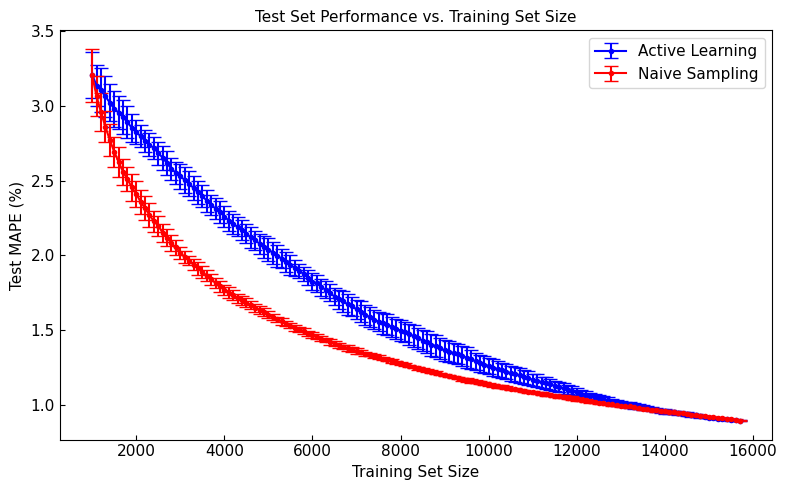

In [ ]:
# plotting the results
plt.figure(figsize=(8,5))
# Use the training sizes from the first run as the common x-axis
plt.errorbar(active_training_sizes[0], active_mean, yerr=active_std, marker='.', linestyle='-', 
             label="Active Learning", color='blue', capsize=5)
plt.errorbar(naive_training_sizes[0], naive_mean, yerr=naive_std, marker='.', linestyle='-', 
             label="Naive Sampling", color='red', capsize=5)
plt.xlabel("Training Set Size", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Test Set Performance vs. Training Set Size", fontsize=11)
plt.tick_params(axis='both', which='both', direction='in', labelsize=11)
plt.legend(fontsize=11)
#plt.grid(True)
plt.tight_layout()
plt.savefig("active_vs_naive_performance.png", dpi=300)
plt.show()

Trying entropy-based sampling

In [ ]:
X_full = optimized_data.drop(columns=['beta_P'])
y_full = optimized_data['beta_P']
X_pool, X_test, y_pool, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [ ]:
# Entropy sampling
def entropy_of_predictions(preds, bins=20, eps=1e-15):
    """
    preds: array-like of shape (n_trees,)
        Predictions from each tree in the ensemble.
    bins: int
        Number of bins to use in the histogram.
    eps: float
        Small offset to avoid log(0).

    Returns:
      float: the entropy in bits (base 2).
    """
    # Build histogram of predictions
    # range=None => auto from data, or specify a plausible range if needed
    hist, bin_edges = np.histogram(preds, bins=bins, density=True)
    # hist sums to ~1 because density=True
    # but due to rounding, we might want to normalize again
    p = hist / (np.sum(hist) + eps)
    # compute entropy
    # sum of -p_i log2(p_i)
    return -np.sum([val * math.log2(val + eps) for val in p])

# Active Learning Function
def run_active_learning(X_pool, y_pool, X_test, y_test,
                       initial_train_size=1000,
                       candidate_sample_size=1000,
                       select_size=100,
                       method='active'):
    """
    Runs one active learning experiment with the specified 'method':
      - 'active' uses standard deviation across tree predictions (original approach).
      - 'naive' picks random points.
      - 'entropy' uses the entropy_of_predictions measure.
    Returns:
      training_sizes: list of training set sizes at each iteration
      test_errors: list of test MAPE values at each iteration
    """
    X_pool_remaining = X_pool.copy()
    y_pool_remaining = y_pool.copy()
    
    # Initial labeled set
    if len(X_pool_remaining) < initial_train_size:
        initial_train_size = len(X_pool_remaining)
    init_idx = np.random.choice(X_pool_remaining.index, size=initial_train_size, replace=False)
    X_train = X_pool_remaining.loc[init_idx].copy()
    y_train = y_pool_remaining.loc[init_idx].copy()
    X_pool_remaining.drop(init_idx, inplace=True)
    y_pool_remaining.drop(init_idx, inplace=True)
    
    training_sizes = [len(X_train)]
    test_errors = []
    
    # Train initial model
    rf_model = RandomForestRegressor(n_estimators=1000, max_depth=20,
                                     max_features=9, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_test = rf_model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    test_errors.append(mape)
    
    # Helper to compute standard deviation across trees
    def std_uncertainty(model, X_candidates):
        preds = np.array([tree.predict(X_candidates) for tree in model.estimators_])
        return np.std(preds, axis=0)
    
    while len(X_pool_remaining) >= select_size:
        # Sample candidate_sample_size from the pool
        if len(X_pool_remaining) < candidate_sample_size:
            candidate_idx = X_pool_remaining.index
        else:
            candidate_idx = np.random.choice(X_pool_remaining.index, size=candidate_sample_size, replace=False)
        X_candidates = X_pool_remaining.loc[candidate_idx]
        
        if method == 'active':
            # standard deviation approach
            uncertainties = std_uncertainty(rf_model, X_candidates)
            selected_indices = X_candidates.index[np.argsort(-uncertainties)[:select_size]]
        elif method == 'entropy':
            # compute entropy for each candidate
            # for each row, get predictions from each tree
            preds_all = np.array([tree.predict(X_candidates) for tree in rf_model.estimators_])  # shape (n_trees, n_candidates)
            entropies = []
            for col_idx, c_idx in enumerate(X_candidates.index):
                row_preds = preds_all[:, col_idx]
                ent = entropy_of_predictions(row_preds, bins=20)
                entropies.append(ent)
            entropies = np.array(entropies)
            selected_indices = X_candidates.index[np.argsort(-entropies)[:select_size]]
        else:
            # naive random
            selected_indices = np.random.choice(X_candidates.index, size=select_size, replace=False)
        
        # "Label" these points
        X_new = X_pool_remaining.loc[selected_indices]
        y_new = y_pool_remaining.loc[selected_indices]
        
        # Add to training set
        X_train = pd.concat([X_train, X_new])
        y_train = pd.concat([y_train, y_new])
        
        # Remove from pool
        X_pool_remaining.drop(selected_indices, inplace=True)
        y_pool_remaining.drop(selected_indices, inplace=True)
        
        training_sizes.append(len(X_train))
        # Retrain model
        rf_model = RandomForestRegressor(n_estimators=1000, max_depth=20,
                                         max_features=9, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred_test = rf_model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        test_errors.append(mape)
    
    return training_sizes, test_errors

# Example comparing the three methods
def compare_three_methods(X_pool, y_pool, X_test, y_test,
                         num_iterations=10, # number of AL iterations
                         runs=5):           # repeat experiment multiple times
    results = {'active': [], 'naive': [], 'entropy': []}
    
    for run in range(runs):
        # For each run, re-split or re-copy the pool
        
        # active
        ts_active, te_active = run_active_learning(X_pool, y_pool, X_test, y_test,
                                                   initial_train_size=1000,
                                                   candidate_sample_size=1000,
                                                   select_size=100,
                                                   method='active')
        results['active'].append((ts_active, te_active))
        
        # naive
        ts_naive, te_naive = run_active_learning(X_pool, y_pool, X_test, y_test,
                                                 initial_train_size=1000,
                                                 candidate_sample_size=1000,
                                                 select_size=100,
                                                 method='naive')
        results['naive'].append((ts_naive, te_naive))
        
        # entropy
        ts_entropy, te_entropy = run_active_learning(X_pool, y_pool, X_test, y_test,
                                                     initial_train_size=1000,
                                                     candidate_sample_size=1000,
                                                     select_size=100,
                                                     method='entropy')
        results['entropy'].append((ts_entropy, te_entropy))
        print(f"Completed run {run+1} of {runs}.")
    
    return results

In [27]:
results = compare_three_methods(X_pool, y_pool, X_test, y_test, runs=3)


Completed run 1 of 3.
Completed run 2 of 3.
Completed run 3 of 3.


In [ ]:
# Extract arrays of training sizes and test errors for each approach and each run
active_ts = np.array([r[0] for r in results['active']])   # shape (runs, n_iterations+1)
active_te = np.array([r[1] for r in results['active']])   # shape (runs, n_iterations+1)

naive_ts = np.array([r[0] for r in results['naive']])
naive_te = np.array([r[1] for r in results['naive']])

entropy_ts = np.array([r[0] for r in results['entropy']])
entropy_te = np.array([r[1] for r in results['entropy']])

# For simplicity, assume each approach yields the same shape of training sizes
training_sizes_active = active_ts[0]
training_sizes_naive  = naive_ts[0]
training_sizes_entropy = entropy_ts[0]

# Compute mean and std across runs for test errors
active_mean = active_te.mean(axis=0)
active_std  = active_te.std(axis=0, ddof=1)

naive_mean  = naive_te.mean(axis=0)
naive_std   = naive_te.std(axis=0, ddof=1)

entropy_mean = entropy_te.mean(axis=0)
entropy_std  = entropy_te.std(axis=0, ddof=1)

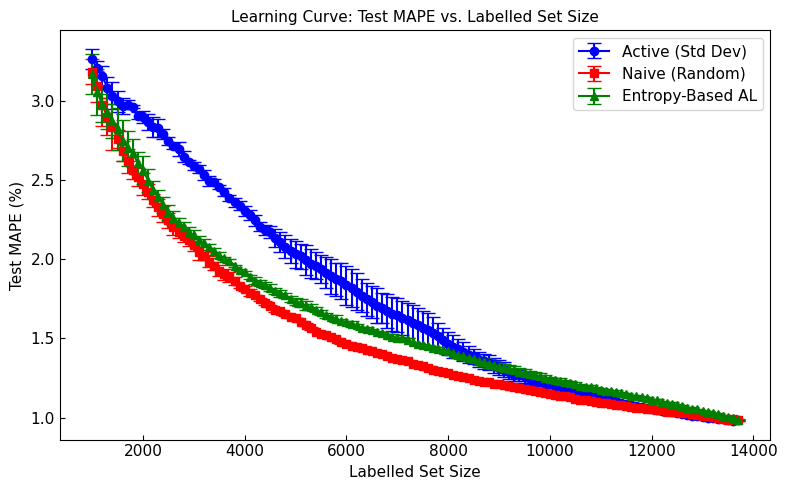

In [ ]:
# Plot the results with error bars
plt.figure(figsize=(8,5))

plt.errorbar(training_sizes_active, active_mean, yerr=active_std,
             marker='.', linestyle='-', color='blue', capsize=5,
             label="Active (Std Dev)")

plt.errorbar(training_sizes_naive, naive_mean, yerr=naive_std,
             marker='.', linestyle='-', color='red', capsize=5,
             label="Naive (Random)")

plt.errorbar(training_sizes_entropy, entropy_mean, yerr=entropy_std,
             marker='.', linestyle='-', color='green', capsize=5,
             label="Entropy-Based AL")

plt.xlabel("Labelled Set Size", fontsize=11)
plt.ylabel("Test MAPE (%)", fontsize=11)
plt.title("Learning Curve: Test MAPE vs. Labelled Set Size", fontsize=11)
plt.tick_params(axis='both', which='both', direction='in', labelsize=11)
#plt.grid(True)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("learning_curve_active_naive_entropy.png", dpi=300)
plt.show()

print("Saved figure: learning_curve_active_naive_entropy.png")

## Going beyond the range 5-10%

Generating data with new parameters, focusing on the 4 features that affect beta_p the most obtained from the feature importance analysis earlier

In [34]:
beyond_params = {
    'q95': 11.5,                    # fixed safety factor 
    'B_max': (1.2,2),               # variable Maximum magnetic field on inboard TF coil 
    'kappa_nat_multip': (1.8,2.7),  # variable natural plasma elongation
    'delta': 0.3,                   # fixed triangularity
    'l_i': 0.7,                     # fixed internal inductance
    'alpha_n': 0.1,                 # fixed density profile peaking factor
    'alpha_T': 1.5,                 # fixed Temperature Peaking Factor
    'f_Greenwald': (1.4,1.8),       # variable  Greenwald fraction
    'f_core_rad': 0.35,             # fixed core Radiation Fraction
    'Z_i': 13.0,                    # fixed  Ion Charge Number 
    'Z_eff': 1.8,                   # fixed  Effective Plasma Charge State
    'EMF': 1.3,                     # fixed neutron Energy Multiplication Factor
    'gamma_CD': 0.18,               # fixed  current drive efficiency factor
    'eta_gen': 0.36,                # fixed  Power Conversion Efficiency
    'eta_CD': 0.4,                  # fixed Current Drive Efficiency
    'f_BOP': 0.25,                  # fixed  Balance of Plant Efficiency Factor. fraction of generated electricity required for the BoP Balance of Plant (BoP)  Here BoP is taken to mean all the recycled power required for reactor operation
    'H': 1.0,                       # fixed Energy Confinement Enhancement Factor
    'A': (1.6,2),                   # variable aspect ratio
    't_shield': 0.0114,             # fixed shield thickness
    'R_cc': 0.3,                    # fixed Radius of leg of inboard TF coil vault
    'Q': 20                         # fixed reactor Q value. Fusion Gain Factor
}

# Generate the new dataset
beyond_data = generate_dataset(beyond_params, n_points_fixed=10)
print("Dataset shape:", beyond_data.shape)  # Should be 10^4 = 10,000 rows
display(beyond_data)

Dataset shape: (10000, 22)


,q95,B_max,kappa_nat_multip,delta,l_i,alpha_n,alpha_T,f_Greenwald,f_core_rad,Z_i,...,gamma_CD,eta_gen,eta_CD,f_BOP,H,A,t_shield,R_cc,Q,beta_P
0,11.5,1.2,1.8,0.3,0.7,0.1,1.5,1.4,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.600000,0.0114,0.3,20,11.024294
1,11.5,1.2,1.8,0.3,0.7,0.1,1.5,1.4,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.644444,0.0114,0.3,20,12.366774
2,11.5,1.2,1.8,0.3,0.7,0.1,1.5,1.4,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.688889,0.0114,0.3,20,14.004105
3,11.5,1.2,1.8,0.3,0.7,0.1,1.5,1.4,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.733333,0.0114,0.3,20,16.042099
4,11.5,1.2,1.8,0.3,0.7,0.1,1.5,1.4,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.777778,0.0114,0.3,20,18.644413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11.5,2.0,2.7,0.3,0.7,0.1,1.5,1.8,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.822222,0.0114,0.3,20,8.174208
9996,11.5,2.0,2.7,0.3,0.7,0.1,1.5,1.8,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.866667,0.0114,0.3,20,8.693885
9997,11.5,2.0,2.7,0.3,0.7,0.1,1.5,1.8,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.911111,0.0114,0.3,20,9.257799
9998,11.5,2.0,2.7,0.3,0.7,0.1,1.5,1.8,0.35,13.0,...,0.18,0.36,0.4,0.25,1.0,1.955556,0.0114,0.3,20,9.871431


Plotting a new histogram

Max beta_P: 84.3108278633578
Mean beta_P: 13.18724304221085
Min beta_P: 4.741308784754732


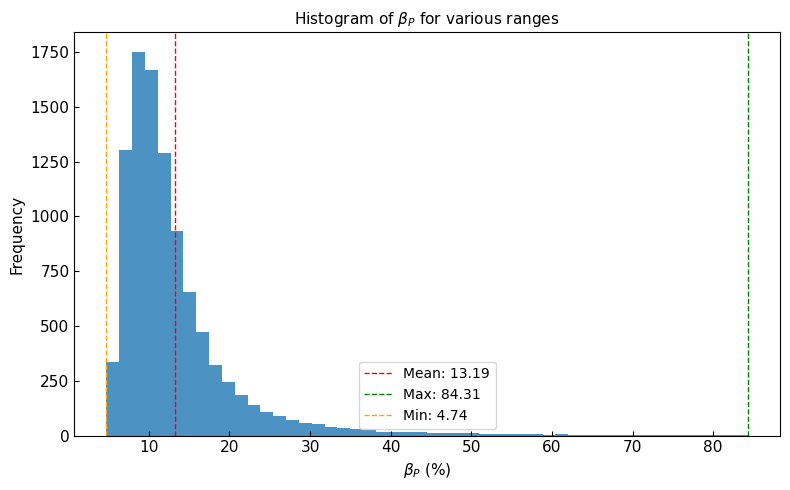

In [35]:
# Remove NaNs from target column
data = beyond_data.dropna(subset=['beta_P'])

# Summary stats
betaP_max = data.beta_P.max()
betaP_mean = data.beta_P.mean()
betaP_min = data.beta_P.min()

print("Max beta_P:", betaP_max)
print("Mean beta_P:", betaP_mean)
print("Min beta_P:", betaP_min)

# Create histogram plot
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(data.beta_P, bins=50, alpha=0.8)

# Label and styling
plt.xlabel(r"$\beta_P$ (%)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.tick_params(axis='both', labelsize=11, direction='in')
plt.title(r"Histogram of $\beta_P$ for various ranges", fontsize=11)

# Overlay vertical lines for stats
plt.axvline(betaP_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {betaP_mean:.2f}')
plt.axvline(betaP_max, color='green', linestyle='dashed', linewidth=1, label=f'Max: {betaP_max:.2f}')
plt.axvline(betaP_min, color='orange', linestyle='dashed', linewidth=1, label=f'Min: {betaP_min:.2f}')

plt.legend()

# Save the figure before showing
plt.tight_layout()
plt.savefig("extrapolated_beta_P_histogram.png", dpi=300, format='png')

# Display the plot
plt.show()


Training on new data using the original optimised hyperparameters

In [36]:
# Define features and target variable
X = beyond_data.drop(columns=['beta_P'])  # Features (reactor parameters)
y = beyond_data['beta_P']  # Target (beta_P)

# Split dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)


In [37]:
# original hyperparameters
rf_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                  max_depth=20, max_features=9, random_state=42)
gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05,
                                     n_estimators=1000, max_depth=5, max_features=9,
                                     random_state=42)

# Train the models
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

# Compute Mean Absolute Percentage Error (MAPE)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions) * 100
gb_mape = mean_absolute_percentage_error(y_test, gb_predictions) * 100

# Display results
model_results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting"],
    "MAPE (%)": [rf_mape, gb_mape],
})

print("ML Model Performance Results:")
print(model_results)

ML Model Performance Results:
               Model  MAPE (%)
0      Random Forest  1.486979
1  Gradient Boosting  0.599816


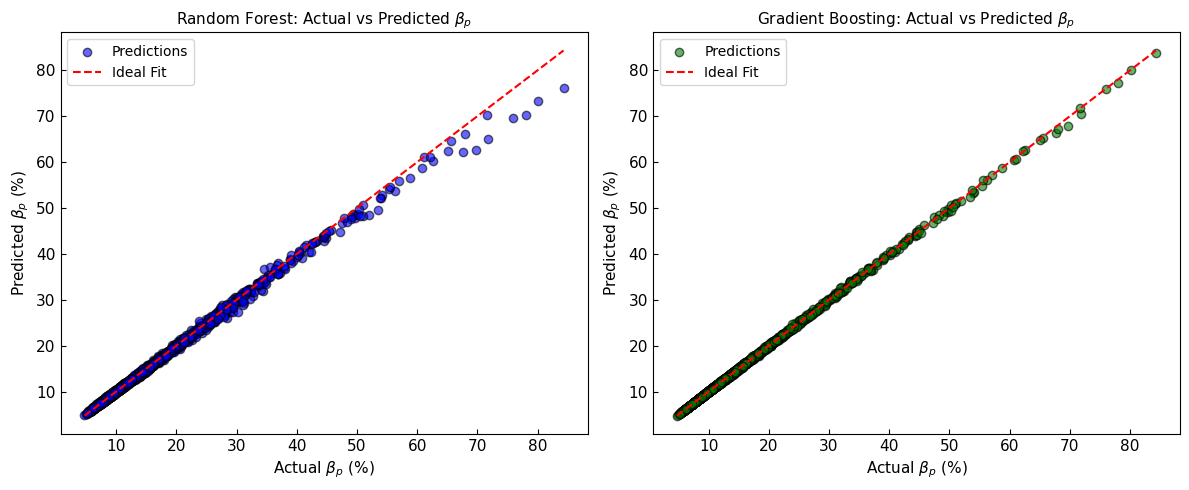

In [38]:
# Scatter Plot: Actual vs Predicted β_P
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Random Forest predictions
axes[0].scatter(y_test, rf_predictions, alpha=0.6, color='blue', edgecolor='k', label='Predictions')
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Fit')
axes[0].set_title("Random Forest: Actual vs Predicted $β_p$", fontsize=11)
axes[0].set_xlabel("Actual $β_p$ (%)", fontsize=11)
axes[0].set_ylabel("Predicted $β_p$ (%)", fontsize=11)
axes[0].tick_params(axis='both', labelsize=11, direction='in')
axes[0].legend()

# Gradient Boosting predictions
axes[1].scatter(y_test, gb_predictions, alpha=0.6, color='green', edgecolor='k', label='Predictions')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Fit')
axes[1].set_title("Gradient Boosting: Actual vs Predicted $β_p$", fontsize=11)
axes[1].set_xlabel("Actual $β_p$ (%)", fontsize=11)
axes[1].set_ylabel("Predicted $β_p$ (%)", fontsize=11)
axes[1].tick_params(axis='both', labelsize=11, direction='in')
axes[1].legend()

plt.tight_layout()

# Save figure
plt.savefig("extrapolated_actual_vs_predicted_betaP_scatter.png", dpi=300)
plt.show()


In [39]:
# Evaluate the best MLP model on the test set
mlp_model = MLPRegressor(hidden_layer_sizes=(20, 20, 10, 10), max_iter=1000, solver='adam', alpha=1e-6, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

# Compute metrics
mlp_test_mape = mean_absolute_percentage_error(y_test, mlp_pred) * 100

# Print results
print(f"MLP Test Set MAPE: {mlp_test_mape:.4f}%")

MLP Test Set MAPE: 5.0905%


Histogram of MAPE for each model vs predicted beta_p for the extrapolated dataset

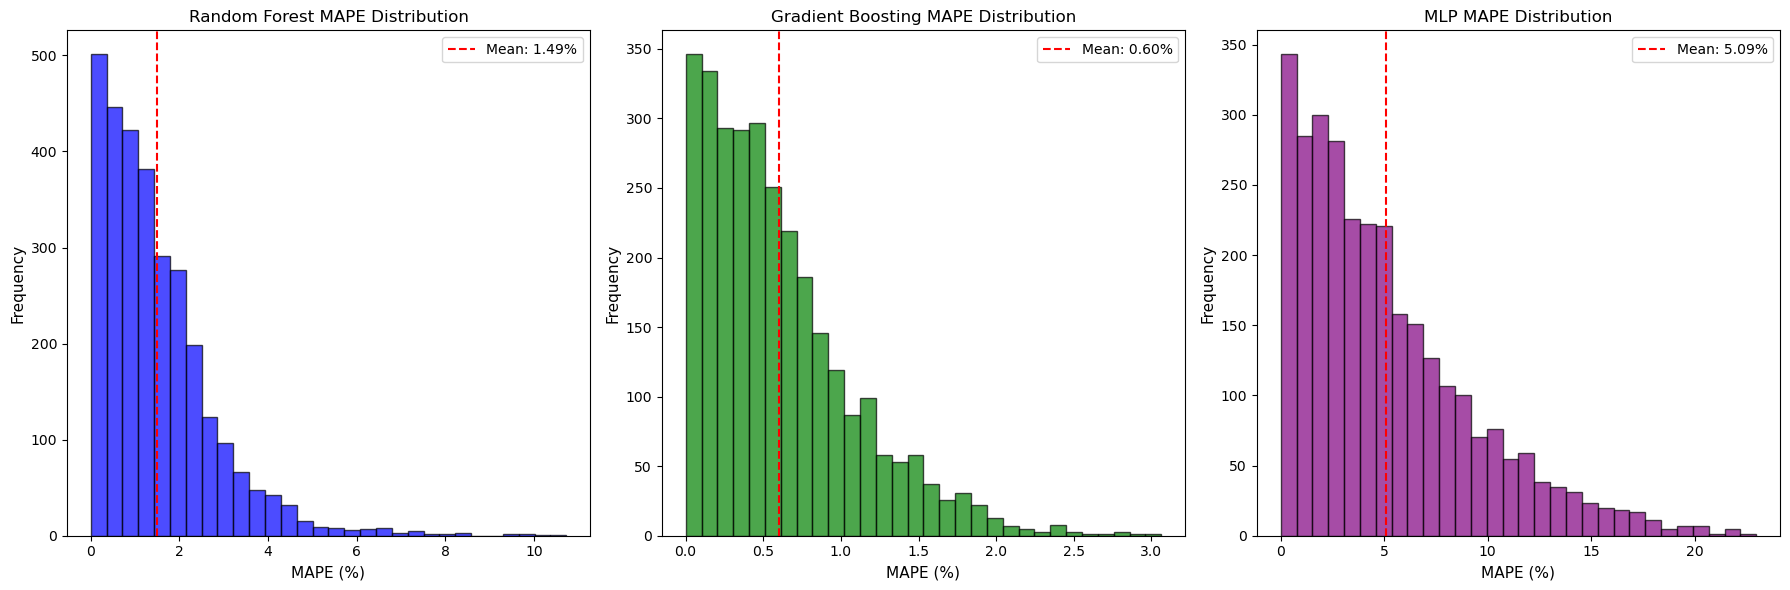

MAPE by beta_P range:


,beta_P_range,RF_MAPE (%),GB_MAPE (%),MLP_MAPE (%)
0,"(2.985, 3.841]",1.17,0.28,2.04
1,"(3.841, 4.688]",0.91,0.28,1.96
2,"(4.688, 5.536]",0.91,0.28,1.68
3,"(5.536, 6.384]",0.94,0.30,1.95
4,"(6.384, 7.232]",0.99,0.27,1.69
5,"(7.232, 8.079]",1.03,0.27,1.28
6,"(8.079, 8.927]",1.25,0.24,1.29
7,"(8.927, 9.775]",1.44,0.26,1.38
8,"(9.775, 10.622]",1.57,0.23,1.88
9,"(10.622, 11.47]",2.87,0.35,3.50


In [43]:
# Calculate residuals and MAPE for each prediction
results_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Predicted': rf_predictions,
    'GB_Predicted': gb_predictions,
    'MLP_Predicted': mlp_pred
})

# Calculate individual MAPE for each data point
results_df['RF_MAPE'] = np.abs((results_df['Actual'] - results_df['RF_Predicted']) / results_df['Actual']) * 100
results_df['GB_MAPE'] = np.abs((results_df['Actual'] - results_df['GB_Predicted']) / results_df['Actual']) * 100
results_df['MLP_MAPE'] = np.abs((results_df['Actual'] - results_df['MLP_Predicted']) / results_df['Actual']) * 100

# Create histograms of MAPE values for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest MAPE histogram
axes[0].hist(results_df['RF_MAPE'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Random Forest MAPE Distribution', fontsize=12)
axes[0].set_xlabel('MAPE (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].axvline(rf_mape, color='red', linestyle='--', label=f'Mean: {rf_mape:.2f}%')
axes[0].legend()

# Gradient Boosting MAPE histogram
axes[1].hist(results_df['GB_MAPE'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Gradient Boosting MAPE Distribution', fontsize=12)
axes[1].set_xlabel('MAPE (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].axvline(gb_mape, color='red', linestyle='--', label=f'Mean: {gb_mape:.2f}%')
axes[1].legend()

# MLP MAPE histogram
axes[2].hist(results_df['MLP_MAPE'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[2].set_title('MLP MAPE Distribution', fontsize=12)
axes[2].set_xlabel('MAPE (%)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].axvline(mlp_test_mape, color='red', linestyle='--', label=f'Mean: {mlp_test_mape:.2f}%')
axes[2].legend()

plt.tight_layout()
plt.savefig("extrapolated_mape_histograms.png", dpi=300)
plt.show()

# Print summary of MAPE by beta_P bin
print("MAPE by beta_P range:")
summary_table = pd.DataFrame({
    'beta_P_range': binned_mape['beta_P_bin'].astype(str),
    'RF_MAPE (%)': binned_mape['RF_MAPE'].round(2),
    'GB_MAPE (%)': binned_mape['GB_MAPE'].round(2),
    'MLP_MAPE (%)': binned_mape['MLP_MAPE'].round(2)
})
display(summary_table)